# Crop Classification with Perturbed Calibration

This notebook shows the workflow of the impact of calibration errors on crop classification using Landsat 8 imagery with USDA Crop Data Layer as ground truth. It uses the Google Earth Engine python API. 



In [ ]:
import ee
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Eo1pTtCAyt0j0brhesGWUScuvl7RNuZzRT6cX8mvnBI&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4T-gppROD-Y0YNdn7C3TQG0NlwHW4JGMRruttkj9lDJoGnlRcYhog

Successfully saved authorization token.


##Data Input and Metadata


1) [USGS Landsat 8 Level 1 Tier 1 Raw Scenes](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1): contains digital numbers (DN), orthorectified, no atmospheric corrections.

2) [USDA Crop Data Layer](https://): Land cover classification of the 48 contiguous states, with 254 possible classes. 


###Map Visualization Function

In [ ]:
#this is from Eric Magliarditi
!pip install geopandas
!pip install julian

import numpy as np
import torch
import PIL
import ee
import folium
from IPython.display import Image
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt
import julian
import plotly.express as px
import plotly.graph_objects as go


def add_ee_layer(self, ee_object, vis_params, name):
	
	try:    
		# display ee.Image()
		if isinstance(ee_object, ee.image.Image):    
			map_id_dict = ee.Image(ee_object).getMapId(vis_params)
			folium.raster_layers.TileLayer(
			tiles = map_id_dict['tile_fetcher'].url_format,
			attr = 'Google Earth Engine',
			name = name,
			overlay = True,
			control = True
			).add_to(self)
		# display ee.ImageCollection()
		elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
			ee_object_new = ee_object.mosaic()
			map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
			folium.raster_layers.TileLayer(
			tiles = map_id_dict['tile_fetcher'].url_format,
			attr = 'Google Earth Engine',
			name = name,
			overlay = True,
			control = True
			).add_to(self)
		# display ee.Geometry()
		elif isinstance(ee_object, ee.geometry.Geometry):    
			folium.GeoJson(
			data = ee_object.getInfo(),
			name = name,
			overlay = True,
			control = True
		).add_to(self)
		# display ee.FeatureCollection()
		elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
			ee_object_new = ee.Image().paint(ee_object, 0, 2)
			map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
			folium.raster_layers.TileLayer(
			tiles = map_id_dict['tile_fetcher'].url_format,
			attr = 'Google Earth Engine',
			name = name,
			overlay = True,
			control = True
		).add_to(self)
	
	except:
		print("Could not display {}".format(name))

folium.Map.add_ee_layer = add_ee_layer


def create_data_table_multi_region(feature_collection, dataset, stat):
	'''
	Creates data table for multiple regions
	'''
	
	size = dataset.size().getInfo()
	images = dataset.toList(dataset.size())
	jan_1_1950 = datetime(1950,1,1)
	df = pd.DataFrame()
	print(size)
	for i in range(size):
		image = images.get(i)
		image_info = image.getInfo()
		image_id = image_info.get("id")
		properties_all = image_info.get('properties')
		days_since_jan_1_1950 = properties_all.get("TIME_REFERENCE_DAYS_SINCE_1950")
		date = jan_1_1950 + timedelta(days=days_since_jan_1_1950)
		julian_date = properties_all.get("TIME_REFERENCE_JULIAN_DAY")
		dt = julian.from_jd(julian_date, fmt='jd')
		system_start = properties_all.get("system:time_start")
		
		ee_image = ee.Image(image_id)
		
		mean_dict = ee_image.reduceRegions(
			reducer=ee.Reducer.mean(),
			collection=feature_collection,
			scale=100)
		
		result = mean_dict.getInfo()
		
		for feature in result.get('features'):
			properties = feature.get('properties')
			if properties.get(stat):
				properties['Date Acquired'] = date #date.strftime("%m/%d/%Y")
				properties['Image ID'] = image_id
				properties['Julian Date'] = dt
				properties['System_Start'] = system_start
				df = df.append(properties, ignore_index=True)
			
	return df

def create_time_df(df):
	unique_dates = df['Date'].unique()
	areas = df['name'].unique()
	new_df = pd.DataFrame()
	ids = []
	for area in areas:
		for date in unique_dates:
			unique_ids = df[(df['Date'] == date) & (df['name'] == area)]['Unique_ID'].to_numpy()
			
			hour = 0
			
			for i in range(len(unique_ids)):
				unique_id = unique_ids[i]
				old_date = date
				new_date = old_date + np.timedelta64(hour, 'h')
				hour += 3
				new_df = new_df.append({'Unique_ID': unique_id, 'New Date': new_date},ignore_index=True)
	return new_df

### Landsat 8 and CDL

#####Cloud Masking Function

In [ ]:
LC8_BANDS = ['B2',   'B3',    'B4',  'B5',  'B6',    'B7',    'B10'];
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp'];

def cloudscore(img):

    def rescale(img1, exp, thresholds):
      return img1.expression(exp, {"img": img1}).subtract(thresholds[0]).divide(thresholds[1] - thresholds[0])

    score = ee.Image(1.0);

    score = score.min(rescale(img, 'img.blue', [0.1, 0.3]));

    score = score.min(rescale(img, 'img.red + img.green + img.blue', [0.2, 0.8]));

    score = score.min(rescale(img, 'img.nir + img.swir1 + img.swir2', [0.3, 0.8]));

    score = score.min(rescale(img, 'img.temp', [300, 290]));

    ndsi = img.normalizedDifference(['green', 'swir1']);

    return score.min(rescale(ndsi, 'img', [0.8, 0.6]));

def badSelect(img):
    # Invert the cloudscore so 1 is least cloudy, and rename the band.
    score = cloudscore(img.select(LC8_BANDS, STD_NAMES))
    score = ee.Image(1).subtract(score).select([0], ['cloudscore'])
    image = img.addBands(score)
    perc_clouds = ee.Number(2500).int();
    cloud = image.select('cloudscore');
    return image.updateMask(cloud.gte(perc_clouds))#;//.copyProperties(image,["system:time_start"]);




In [ ]:

#/////////////////////////////////////////////////////////////////////////////////////
#//IMPORT CDL GROUND TRUTH
#/////////////////////////////////////////////////////////////////////////////////////

ground_truth = ee.ImageCollection('USDA/NASS/CDL')\
                    .filter(ee.Filter.date('2019-01-01', '2019-12-31'))\
                    .first()

classvalue = ground_truth.get('cropland_class_values')#; //Type: LIST OF POSSIBLE VALUES
 
#  //print("classvalue", classvalue);

croplandcover = ee.Image(ground_truth.select('cropland'))#; // Type: IMAGE
#print("croplandcover", croplandcover)
#  //print(ground_truth, "what are all the occuring veggies");

##NOT SURE WHAT'S GOING ON HERE
#classes = croplandcover.reduceToVectors({
#    reducer: ee.Reducer.countEvery(), 
#    scale: 30,
#    maxPixels: 1e8
#  });# //Type: FEATURE COLLECTION (essentially a vector)


#/////////////////////////////////////////////////////////////////////////////////////
#//CDL METADATA RAW IMAGES
#//sourced from : https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ca19.htm
#/////////////////////////////////////////////////////////////////////////////////////


#//****************************************************************
#//** ILLINOIS
#//** https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_il19.htm
#//****************************************************************


#//20190523 PATH 024

raw_illi_1 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 24))\
  .filter(ee.Filter.eq('WRS_ROW', 32))\
  .filterDate('2019-05-22', '2019-05-24')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()
#//20190601 PATH 023

raw_illi_2 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 23))\
  .filter(ee.Filter.eq('WRS_ROW', 32))\
  .filterDate('2019-06-01', '2019-06-02')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()
#print(raw_illi_2)

#//20190719 PATH 023
raw_illi_4 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 23))\
  .filter(ee.Filter.eq('WRS_ROW', 32))\
  .filterDate('2019-07-19', '2019-07-20')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()

#//20190827 PATH 024

raw_illi_5 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filterDate('2019-08-27', '2019-08-28')\
  .filter(ee.Filter.eq('WRS_PATH', 24))\
  .filter(ee.Filter.eq('WRS_ROW', 32))\
  .sort('CLOUD_COVER')\
  .first()

#//20190829 PATH 022

#raw_illi_6 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
#  .filter(ee.Filter.eq('WRS_PATH', 22))\
#  .filter(ee.Filter.eq('WRS_ROW', 32))\
#  .filterDate('2019-08-29', '2019-08-30')\
#  .sort('CLOUD_COVER')\
#  .first()  

#//20190905 PATH 023

raw_illi_7 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 23))\
  .filter(ee.Filter.eq('WRS_ROW', 32))\
  .filterDate('2019-09-05', '2019-09-06')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()
#ILLINOIS ARRAY

raw_illi_list = [raw_illi_1, raw_illi_2, raw_illi_4, raw_illi_5, raw_illi_7]
raw_illi_collection = ee.ImageCollection(raw_illi_list)


range = raw_illi_collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])

illi_date_range = [ee.Date(range.get('min')).format('YYYY-MM-dd').getInfo(), ee.Date(range.get('max')).format('YYYY-MM-dd').getInfo()]

print(illi_date_range)


#//****************************************************************
#//** CALIFORNIA
#//** sourced from : https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ca19.htm3//****************************************************************
#//****************************************************************


#//20190604 PATH 044
raw_cali_1 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 44))\
  .filter(ee.Filter.eq('WRS_ROW', 33))\
  .filterDate('2019-06-01', '2019-06-06')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()

#//20190706 PATH 044
raw_cali_2 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 44))\
  .filter(ee.Filter.eq('WRS_ROW', 33))\
  .filterDate('2019-07-04', '2019-07-07')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()

#//20190719 PATH 039
# raw_cali_3 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
#   .filter(ee.Filter.eq('WRS_PATH', 39))\
#   .filter(ee.Filter.eq('WRS_ROW', 33))\
#   .filterDate('2019-07-18', '2019-07-20')\
#   .sort('CLOUD_COVER')\
#   .first() #THIS IS SHOT

#//20190814 PATH 045

raw_cali_4 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 45))\
  .filter(ee.Filter.eq('WRS_ROW', 33))\
  .filterDate('2019-08-13', '2019-08-15')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()

#//20190823 PATH 044
raw_cali_5 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 44))\
  .filter(ee.Filter.eq('WRS_ROW', 33))\
  .filterDate('2019-08-22', '2019-08-24')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()

print("raw cali", raw_cali_5.getInfo())
#//20190908 PATH 044
raw_cali_6 = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
  .filter(ee.Filter.eq('WRS_PATH', 44))\
  .filter(ee.Filter.eq('WRS_ROW', 33))\
  .filterDate('2019-09-07', '2019-09-09')\
  .map(badSelect)\
  .sort('CLOUD_COVER')\
  .first()



raw_cali_list = [raw_cali_1, raw_cali_2, raw_cali_4, raw_cali_5, raw_cali_6]
raw_cali_collection = ee.ImageCollection(raw_cali_list)


#get the date range

range = raw_cali_collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
cali_date_range = [ee.Date(range.get('min')).format('YYYY-MM-dd').getInfo(), ee.Date(range.get('max')).format('YYYY-MM-dd').getInfo()]
print(cali_date_range)

['2019-05-23', '2019-09-05']
raw cali {'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7661, 7791], 'crs': 'EPSG:32610', 'crs_transform': [30, 0, 501285, 0, -30, 4423215]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7661, 7791], 'crs': 'EPSG:32610', 'crs_transform': [30, 0, 501285, 0, -30, 4423215]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7661, 7791], 'crs': 'EPSG:32610', 'crs_transform': [30, 0, 501285, 0, -30, 4423215]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7661, 7791], 'crs': 'EPSG:32610', 'crs_transform': [30, 0, 501285, 0, -30, 4423215]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7661, 7791], 'crs': 'EPSG:32610', 'crs_transform':

### Areas of Interest

In [ ]:
#geometries

areaM2 = (2*(10**3))**2 #[units m2]

illi_poi = ee.Geometry.Point(coords = [-89.52067251922702, 40.89257394031094])
cali_poi = ee.Geometry.Point(coords = [-122.18052741330365, 39.30738727084469])

#REGIONS OF INTEREST

roi_illi = illi_poi.buffer(ee.Number(areaM2).sqrt().divide(2), 1).bounds()
roi_illi_area = roi_illi.area(0.001).getInfo() / ((10**3)**2)
roi_illi_coords = roi_illi.centroid(0.001).getInfo()

roi_cali = cali_poi.buffer(ee.Number(areaM2).sqrt().divide(2), 1).bounds()
roi_cali_area = roi_cali.area(0.001).getInfo() / ((10**3)**2)
roi_cali_coords = roi_cali.centroid(0.001).getInfo()


#Print results
print("area of Illinois region of interest", roi_illi_area, "square km", roi_illi_coords)
print("area of California region of interest", roi_cali_area, "square km", roi_cali_coords)



area of Illinois region of interest 4.003523763907841 square km {'type': 'Point', 'coordinates': [-89.52067506458178, 40.89257471260083]}
area of California region of interest 4.0035234599717855 square km {'type': 'Point', 'coordinates': [-122.1805299018495, 39.30738805420493]}


####Visualize the input data

In [ ]:
#Visually inspect the patches


import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import IPython.display as disp

##THESE ARE FOR ILLINOIS
parameters_illi = {'min': 0,
              'max': 20000,
              'dimensions': 256,
              'bands': ['B4', 'B3', 'B2'],
              'region': roi_illi}

parameters_cali = {'min': 0,
              'max': 20000,
              'dimensions': 256,
              'bands': ['B4', 'B3', 'B2'],
              'region': roi_cali}

for i, val in enumerate(raw_illi_list):
  print("raw illi "+str(i + 1), val.getThumbUrl(parameters_illi))
  print(ee.Date(val.get('system:time_start')).format('MM/dd/yyyy').getInfo())

for i, val in enumerate(raw_cali_list):
  print("raw cali "+str(i + 1), val.getThumbUrl(parameters_cali))
  print(ee.Date(val.get('system:time_start')).format('MM/dd/yyyy').getInfo())

raw illi 1 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/545cadcd51b8eb088de5a9693b56c52c-a590d58e24ef0746f1fb2c688629cfb1:getPixels
05/23/2019
raw illi 2 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/864cca8a43964f7855065ad0d70155ea-304d55ea73ee403a6ecb680fa95a0cbb:getPixels
06/01/2019
raw illi 3 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f1177397deea9f7fb524132d921421fa-9961259785963d4d371ac536e76e3209:getPixels
07/19/2019
raw illi 4 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4dd585a62ad806b9ce720f4a09139926-e72a4d4589b342b83d77f38b066d544c:getPixels
08/27/2019
raw illi 5 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5bc126f81adb666143e1756a3e80d5ef-a23d9f5dc697347db4a8b2d857196a57:getPixels
09/05/2019
raw cali 1 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f1923a3

In [ ]:
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.

# Create a folium map object.
my_map = folium.Map(location=[45.5236, -122.6750], zoom_start=3, height=500)

# Add Crop Data Layer
my_map.add_ee_layer(croplandcover, {}, 'crop cover')
#for visualizing the Landsat imagery, specify the bands: 

vis_params = {'bands':['B4','B3','B2'], 'min': 0, 'max': 0.5, 'gamma': 1.4}
vis_params_dn = {'bands':['B4','B3','B2'], 'min': 0, 'max': 20000, 'gamma': 1.4}

#my_map.add_ee_layer(raw0, vis_params, 'raw0')

#my_map.add_ee_layer(raw_cali_5, vis_params_dn, 'image')

my_map.add_ee_layer(raw_cali_collection, vis_params_dn, 'image')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)


In [ ]:
#CROP DATA LAYER DATA (Type: Image)
ground_truth = ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date('2019-01-01', '2019-12-31')).first()

croplandcover = ee.Image(ground_truth.select('cropland'))
#get information about the output ee.Image
#print(croplandcover.getInfo())

In [ ]:
#/////////////////////////////////////////////////////////////////////////////////////
#//VISUALIZE THE INPUT DATA
#/////////////////////////////////////////////////////////////////////////////////////

# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.

folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.

# Create a folium map object.
my_map = folium.Map(location=[45.5236, -122.6750], zoom_start=3, height=500)

# Add Crop Data Layer
my_map.add_ee_layer(croplandcover, {}, 'crop cover')
#for visualizing the Landsat imagery, specify the bands: 

vis_params = {'bands':['B4','B3','B2'], 'min': 0, 'max': 0.5, 'gamma': 1.4}
vis_params_dn = {'bands':['B4','B3','B2'], 'min': 0, 'max': 20000, 'gamma': 1.4}

#my_map.add_ee_layer(raw0, vis_params, 'raw0')


my_map.add_ee_layer(raw_cali_1, vis_params_dn, 'image')
my_map.add_ee_layer(raw_cali_2, vis_params_dn, 'image')
#my_map.add_ee_layer(raw_cali_3, vis_params_dn, 'image')
my_map.add_ee_layer(raw_cali_4, vis_params_dn, 'image')
my_map.add_ee_layer(raw_cali_5, vis_params_dn, 'image')



#Mapdisplay([0, 0],{'glc30':glc30_ecuador.getMapId(vizparams)},zoom_start=10)


# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)



### Landsat 8 gains for DN to TOA

####Reflectance gain coefficients

In [ ]:
#list of gain coefficients for reflectance

def ref_mult(img):
  '''
  :input ee.Image
  :ouptut an ee.List of gains based on the metadata
  '''
  ref_mult = img.set('REF_MULTS_BANDS[1,2,3,4,5,6,7,9]', ee.List([img.get('REFLECTANCE_MULT_BAND_1'),\
                                                      img.get('REFLECTANCE_MULT_BAND_2'),\
                                                      img.get('REFLECTANCE_MULT_BAND_3'),\
                                                      img.get('REFLECTANCE_MULT_BAND_4'),\
                                                      img.get('REFLECTANCE_MULT_BAND_5'),\
                                                      img.get('REFLECTANCE_MULT_BAND_6'),\
                                                      img.get('REFLECTANCE_MULT_BAND_7'),\
                                                      img.get('REFLECTANCE_MULT_BAND_9')]))

  return ref_mult


####Reflectance bias coefficients

In [ ]:
#list of biases for reflectance
def ref_add(img):
  ref_adds = img.set('REF_ADDS_BANDS[1,2,3,4,5,6,7,9]', ee.List([img.get('REFLECTANCE_ADD_BAND_1'),\
                                                      img.get('REFLECTANCE_ADD_BAND_2'),\
                                                      img.get('REFLECTANCE_ADD_BAND_3'),\
                                                      img.get('REFLECTANCE_ADD_BAND_4'),\
                                                      img.get('REFLECTANCE_ADD_BAND_5'),\
                                                      img.get('REFLECTANCE_ADD_BAND_6'),\
                                                      img.get('REFLECTANCE_ADD_BAND_7'),\
                                                      img.get('REFLECTANCE_ADD_BAND_9')]))

  return ref_adds#ee.List([ref1, ref2, ref3, ref4, ref5, ref6, ref7, ref9])


#print(raw_cali_collection.getInfo())
#raw_datas = ee.ImageCollection(raw_cali_collection).map(ref_add)

#print(raw_datas.getInfo())

#print("ehem", raw_datas.get('REF_ADD_BANDS[1,2,3,4,5,6,7,9]').getInfo())


####DN to TOA transformation

In [ ]:
#function for transforming DN to TOA 
#your regular friendly neighborhood transformation
def toa_reflectance(image):
    '''
    :params
      - ee.Image (raw)
      - list of  mult coefficients (regular list)
      -  bias list (ee.List)
    returns TOA image
    '''
    mult_list = ee.List(image.get('REF_MULTS_BANDS[1,2,3,4,5,6,7,9]'))
    add_list = ee.List(image.get('REF_ADDS_BANDS[1,2,3,4,5,6,7,9]'))
    sun_ang = ee.Number(image.get('SUN_ELEVATION'))
    sine_val = ee.Number(sun_ang.multiply(math.pi).divide(180).sin())#radians
    constant = ee.Number(1).divide(sine_val)
    #now for the bands
    band1 = image.select("B1")
    band2 = image.select("B2")
    band3 = image.select("B3")
    band4 = image.select("B4")
    band5 = image.select("B5")
    band6 = image.select("B6")
    band7 = image.select("B7")
    band9 = image.select("B9")
    bqa   = image.select("BQA")
    
    band_list = ee.List([band1, band2, band3, band4, band5, band6, band7, band9])
    toa_1 = band1.multiply(ee.Number(mult_list.get(0))).add(ee.Number(add_list.get(0))).multiply(ee.Number(constant))
    toa_2 = band2.multiply(ee.Number(mult_list.get(1))).add(ee.Number(add_list.get(1))).multiply(ee.Number(constant))
    toa_3 = band3.multiply(ee.Number(mult_list.get(2))).add(ee.Number(add_list.get(2))).multiply(ee.Number(constant))
    toa_4 = band4.multiply(ee.Number(mult_list.get(3))).add(ee.Number(add_list.get(3))).multiply(ee.Number(constant))      
    toa_5 = band5.multiply(ee.Number(mult_list.get(4))).add(ee.Number(add_list.get(4))).multiply(ee.Number(constant))
    toa_6 = band6.multiply(ee.Number(mult_list.get(5))).add(ee.Number(add_list.get(5))).multiply(ee.Number(constant))
    toa_7 = band7.multiply(ee.Number(mult_list.get(6))).add(ee.Number(add_list.get(6))).multiply(ee.Number(constant))
    toa_9 = band9.multiply(ee.Number(mult_list.get(7))).add(ee.Number(add_list.get(7))).multiply(ee.Number(constant))
  
    toa = ee.Image.cat([toa_1, toa_2, toa_3, toa_4, toa_5, toa_6, toa_7, toa_9, bqa])

    return toa;

#toa_cali = ee.ImageCollection(raw_cali_collection).map(ref_mult).map(ref_add).map(toa_reflectance)
#print("does this work", toa_cali.getInfo())


#####Visualize the TOA reflectance data

In [ ]:
#Visually inspect the patches


import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import IPython.display as disp

##THESE ARE FOR ILLINOIS
parameters_illi = {'min': 0,
              'max': 0.4,
              'dimensions': 256,
              'bands': ['B4', 'B3', 'B2'],
              'region': roi_illi}

parameters_cali = {'min': 0,
              'max': 0.4,
              'dimensions': 256,
              'bands': ['B4', 'B3', 'B2'],
              'region': roi_cali}

disp.Image(url = toa_reflectance(ref_add(ref_mult((raw_illi_4)))).getThumbUrl(parameters_illi))



##Creating Indices

For classification, adding indices often improve performance. In this case, we are using the following indices:




*   NDVI

* Rouse, J.W, Haas, R.H., Scheel, J.A., and Deering, D.W. (1974) 'Monitoring Vegetation Systems in the Great Plains with ERTS.' Proceedings, 3rd Earth Resource Technology Satellite (ERTS) Symposium, vol. 1, p. 48-62. 

*   MNDWI (Modified Normalized Difference Water Index - Hanqiu Xu, 2006)


* Xu, H. (2006). Modification of normalised difference water index (NDWI) to enhance open water features in remotely sensed imagery. International journal of remote sensing, 27(14), 3025-3033.


*   SR
*   Band Ratio 54
*   Band Ratio 35
*   GCVI  
* Gitelson, A. A., Viña, A., Arkebauer, T. J., Rundquist, D. C., Keydan, G., & Leavitt, B. (2003). Remote estimation of leaf area index and green leaf biomass in maize canopies. Geophysical research letters, 30(5).
*   NDBI



In [ ]:
# This function maps spectral indices using Landsat 8 Imagery//TODO: POTENTIALLY ADD MORE
def addIndicesL8(image):
      #NDVI
      ndvi = image.normalizedDifference(['B5','B4']).rename('NDVI');
      #NDMI (Normalized Difference Mangrove Index - Shi et al 2016 - New spectral metrics for mangrove forest identification)
      ndmi = image.normalizedDifference(['B7','B3']).rename('NDMI');
      #MNDWI (Modified Normalized Difference Water Index - Hanqiu Xu, 2006)
      mndwi = image.normalizedDifference(['B3','B6']).rename('MNDWI');
      #SR (Simple Ratio)
      sr = image.select('B5').divide(image.select('B4')).rename('SR');
      #Band Ratio 54
      ratio54 = image.select('B6').divide(image.select('B5')).rename('R54');
      #Band Ratio 35
      ratio35 = image.select('B4').divide(image.select('B6')).rename('R35');
      #GCVI
      gcvi = image.expression('(NIR/GREEN)-1',{
        'NIR':image.select('B5'),
        'GREEN':image.select('B3')
        }).rename('GCVI');
        #NDBI - Zha, Y., J. Gao, and S. Ni. "Use of Normalized Difference Built-Up Index in Automatically Mapping Urban Areas from TM Imagery." International Journal of Remote Sensing 24, no. 3 (2003): 583-594.
      ndbi = image.normalizedDifference(['B6','B5']).rename('NDBI');  
      return image\
      .addBands(ndvi)\
      .addBands(ndmi)\
      .addBands(mndwi)\
      .addBands(sr)\
      .addBands(ratio54)\
      .addBands(ratio35)\
      .addBands(gcvi)\
      .addBands(ndbi)


##Band Perturbation

To introduce calibration error, we bring in a matrix of possible band perturbations ranging from -2% to 2% at an increment of 0.25%. This array is stored on a Google Sheet, so first we must authenticate ourselves on Google Drive.

### One Band Perturbation matrix
This is when we are ignoring cross coupling effects and investigating the impact of one individual band. 

In [ ]:
import numpy as np
#to systematically build trial matrices
def oneband_mat(bandname, perc_abs_range, perc_increment):
  '''
  input: bandname, the band to perturb, a string
  abs_range: float, the limits to perturb, ex: |2%| = 2.0
  increment: float, steps to perturb the bands by (ex: 0.1% = 0.1)
  output: an ee.Array that can be fed into perturbations hopefully
  '''
  abs_range = perc_abs_range/ 100
  increment = perc_increment / 100 
  
  if bandname == 'B9':
    col_index = 7
  elif bandname == 'B8':
    return 'Cannot use panchromatic' 
  else:
    col_index = int(bandname[-1]) - 1
  
  start = float(1 - abs_range)
  end = float(1 + abs_range)

  mat = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
  mat[col_index] = start
  start += increment
  while start < end:
    new_row = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    new_row[col_index] = float(start)
    start += increment 
    mat = np.vstack((mat, new_row))
    #mat1 = ee.Array(mat.tolist())
  return mat.tolist()


### Perturbation function 

In [ ]:
##USE THIS FOR NOW
def perturb_image(row):
  def toa_reflectance(image):
      '''
      :params
        - ee.Image (raw)
        - list of  mult coefficients (regular list)
        -  bias list (ee.List)
      returns TOA image
      '''
      #ee.Array(refmult_list).multiply(ee.Array(pert_array)).toList()
      mult_list = ee.List(image.get('REF_MULTS_BANDS[1,2,3,4,5,6,7,9]'))
      add_list = ee.List(image.get('REF_ADDS_BANDS[1,2,3,4,5,6,7,9]'))
      sun_ang = ee.Number(image.get('SUN_ELEVATION'))
      sine_val = ee.Number(sun_ang.multiply(math.pi).divide(180).sin())#radians
      constant = ee.Number(1).divide(sine_val)
      #now for the bands
      band1 = image.select("B1")
      band2 = image.select("B2")
      band3 = image.select("B3")
      band4 = image.select("B4")
      band5 = image.select("B5")
      band6 = image.select("B6")
      band7 = image.select("B7")
      band9 = image.select("B9")
      bqa   = image.select("BQA")
      
      band_list = ee.List([band1, band2, band3, band4, band5, band6, band7, band9])



      toa_1 = band1.multiply(ee.Number(mult_list.get(0)).multiply(row.get(0))).add(ee.Number(add_list.get(0))).multiply(ee.Number(constant))
      toa_2 = band2.multiply(ee.Number(mult_list.get(1)).multiply(row.get(1))).add(ee.Number(add_list.get(1))).multiply(ee.Number(constant))
      toa_3 = band3.multiply(ee.Number(mult_list.get(2)).multiply(row.get(2))).add(ee.Number(add_list.get(2))).multiply(ee.Number(constant))
      toa_4 = band4.multiply(ee.Number(mult_list.get(3)).multiply(row.get(3))).add(ee.Number(add_list.get(3))).multiply(ee.Number(constant))      
      toa_5 = band5.multiply(ee.Number(mult_list.get(4)).multiply(row.get(4))).add(ee.Number(add_list.get(4))).multiply(ee.Number(constant))
      toa_6 = band6.multiply(ee.Number(mult_list.get(5)).multiply(row.get(5))).add(ee.Number(add_list.get(5))).multiply(ee.Number(constant))
      toa_7 = band7.multiply(ee.Number(mult_list.get(6)).multiply(row.get(6))).add(ee.Number(add_list.get(6))).multiply(ee.Number(constant))
      toa_9 = band9.multiply(ee.Number(mult_list.get(7)).multiply(row.get(7))).add(ee.Number(add_list.get(7))).multiply(ee.Number(constant))
    
      toa = ee.Image.cat([toa_1, toa_2, toa_3, toa_4, toa_5, toa_6, toa_7, toa_9, bqa])
      return toa

  return toa_reflectance



##Applying perturbation to Image

Here we will get the perturbation matrices and apply them across the ee.ImageCollection. In return we get an image collection with perturbed bands.

In [ ]:
def mats(perc_abs_range, perc_increment):
  mat1 = oneband_mat('B1', perc_abs_range, perc_increment) #for now export it as a numpy array
  mat2 = oneband_mat('B2', perc_abs_range, perc_increment) #for now export it as a numpy array
  mat3 = oneband_mat('B3', perc_abs_range, perc_increment) #for now export it as a numpy array
  mat4 = oneband_mat('B4', perc_abs_range, perc_increment) #for now export it as a numpy array
  mat5 = oneband_mat('B5', perc_abs_range, perc_increment) #for now export it as a numpy array
  mat6 = oneband_mat('B6', perc_abs_range, perc_increment) #for now export it as a numpy array
  mat7 = oneband_mat('B7', perc_abs_range, perc_increment) #for now export it as a numpy array
  #mat8 = oneband_mat('B8', perc_abs_range, perc_increment) #for now export it as a numpy array
  mat9 = oneband_mat('B9', perc_abs_range, perc_increment) #for now export it as a numpy array

  return [mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat9]

def get_images_perturbed(image_collection):  
  images_total = []
  for matrix in mat_humongous:
    images_new = []
    for row in matrix:
      images_new.append(image_collection.map(perturb_image(ee.List(row))))
    images_total.append(images_new)
  return ee.List(images_total)


###actually applying it now 

mat_humongous = mats(1, 0.1)
print(mat_humongous)
print(np.array(mat_humongous).shape)
#toa_cali_2 = ref_add(ref_mult(raw_cali_2))
#thing = perturb_image(row1)(toa_cali_2)

#raw_calis = raw_cali_collection.map(ref_mult).map(ref_add).map(maskL8).filterBounds(roi_cali)

#this should really become a function


#print(ee.List(images_total).getInfo())

#print( get_images_perturbed(raw_calis).getInfo())

[[[0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.009999999999999

##Assessing NDVI

First we look at the effect of perturbation on the NDVI. 

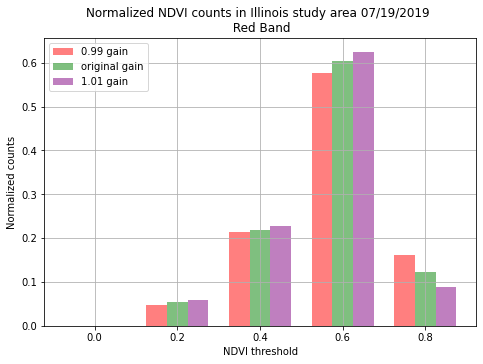

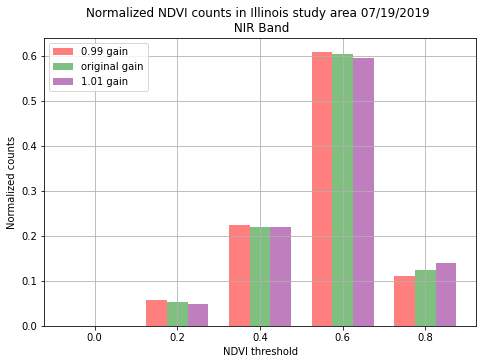

In [ ]:
#plot the histograms

raw_calis = raw_cali_collection.map(ref_mult).map(ref_add).map(badSelect).filterBounds(roi_cali)



###PERTURBING RED BAND
toa_illi_4 = ref_add(ref_mult(raw_illi_4))
illi_4_toa_unperturbed = addIndicesL8(toa_reflectance(ref_add(ref_mult(raw_illi_4))))
  
#bands = ['B1', 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'NDVI', 'NDBI', 'MNDWI', 'GCVI']
row_minus = [1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0]
row_plus = [1.0, 1.0, 1.0, 1.01, 1.0, 1.0, 1.0, 1.0]

illi_4_toa_plus = perturb_image(ee.List(row_plus))(toa_illi_4)
illi_4_toa_minus = perturb_image(ee.List(row_minus))(toa_illi_4)


import matplotlib.pyplot as plt

def IndexHisto(img, img_plus, img_minus):
  '''
  indexname should be a string with quotations ex: 'NDVI'
  '''
  
  # This function maps spectral indices using Landsat 8 Imagery//TODO: POTENTIALLY ADD MORE
  
  def indicise(image):
    indicised = addIndicesL8(image)
    selected = indicised.select('NDVI')
    a = np.array(selected.reduceRegion(ee.Reducer.fixedHistogram(0, 1.0, 5), roi_illi).get('NDVI').getInfo())
    x = a[:, 0]
    y = a[:, 1] / np.sum(a[:, 1])
    return x, y
    #gcvi = np.array(indicised.select('GCVI').getInfo())
  
  unperturbed = indicise(img)
  plus = indicise(img_plus)
  minus = indicise(img_minus)

  legend_size = 10
  fig = plt.figure()

  ax = fig.add_axes([0,0,1,1])
  plt.grid()
  plt.bar(minus[0] - 0.05, minus[1], width = 0.05, color = 'r', alpha = 0.5, label = "0.99 gain")
  plt.bar(unperturbed[0], unperturbed[1], width = 0.05, color = 'g', alpha = 0.5, label = "original gain")
  plt.bar(plus[0] + 0.05 , plus[1], width = 0.05, color = 'purple', alpha = 0.5, label = "1.01 gain")

  plt.title("Normalized NDVI counts in Illinois study area 07/19/2019 \n Red Band")
  plt.xlabel('NDVI threshold')
  plt.ylabel('Normalized counts')

  plt.legend(loc='best', fancybox=True, fontsize = legend_size)

  plt.show()

IndexHisto(illi_4_toa_unperturbed, illi_4_toa_plus, illi_4_toa_minus)



###PERTURBING NIR BAND 
toa_illi_4 = ref_add(ref_mult(raw_illi_4))
illi_4_toa_unperturbed = addIndicesL8(toa_reflectance(ref_add(ref_mult(raw_illi_4))))
  
#bands = ['B1', 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'NDVI', 'NDBI', 'MNDWI', 'GCVI']
row_minus = [1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0]
row_plus = [1.0, 1.0, 1.0, 1.0, 1.01, 1.0, 1.0, 1.0]

illi_4_toa_plus = perturb_image(ee.List(row_plus))(toa_illi_4)
illi_4_toa_minus = perturb_image(ee.List(row_minus))(toa_illi_4)


import matplotlib.pyplot as plt

def IndexHisto(img, img_plus, img_minus):
  '''
  indexname should be a string with quotations ex: 'NDVI'
  '''
  
  # This function maps spectral indices using Landsat 8 Imagery//TODO: POTENTIALLY ADD MORE
  
  def indicise(image):
    indicised = addIndicesL8(image)
    selected = indicised.select('NDVI')
    a = np.array(selected.reduceRegion(ee.Reducer.fixedHistogram(0, 1.0, 5), roi_illi).get('NDVI').getInfo())
    x = a[:, 0]
    y = a[:, 1] / np.sum(a[:, 1])
    return x, y
    #gcvi = np.array(indicised.select('GCVI').getInfo())
  
  unperturbed = indicise(img)
  plus = indicise(img_plus)
  minus = indicise(img_minus)

  legend_size = 10
  fig = plt.figure()

  ax = fig.add_axes([0,0,1,1])
  plt.grid()
  plt.bar(minus[0] - 0.05, minus[1], width = 0.05, color = 'r', alpha = 0.5, label = "0.99 gain")
  plt.bar(unperturbed[0], unperturbed[1], width = 0.05, color = 'g', alpha = 0.5, label = "original gain")
  plt.bar(plus[0] + 0.05 , plus[1], width = 0.05, color = 'purple', alpha = 0.5, label = "1.01 gain")

  plt.title("Normalized NDVI counts in Illinois study area 07/19/2019 \n NIR Band")
  plt.xlabel('NDVI threshold')
  plt.ylabel('Normalized counts')

  plt.legend(loc='best', fancybox=True, fontsize = legend_size)

  plt.show()

IndexHisto(illi_4_toa_unperturbed, illi_4_toa_plus, illi_4_toa_minus)






##Classifying Landcover



###Classes from ground truth

In [ ]:
#We need to get the classes for each area of interest


classes_cali = croplandcover.reduceToVectors(reducer = ee.Reducer.countEvery(),
                                        geometry =  roi_cali,
                                        geometryType = 'polygon',
                                        scale = 30,
                                        maxPixels = 1e8,
                                        labelProperty = 'label')

classes_illi = croplandcover.reduceToVectors(reducer = ee.Reducer.countEvery(),
                                        geometry =  roi_illi,
                                        geometryType = 'polygon',
                                        scale = 30,
                                        maxPixels = 1e8,
                                        labelProperty = 'label')

print("classes illi", classes_illi.getInfo())

classes illi {'type': 'FeatureCollection', 'columns': {'count': 'Long<0, 4294967295>', 'label': 'Short<0, 255>', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-89.53242357761603, 40.90133229421302], [-89.53244799229289, 40.90106501592018], [-89.53208980230633, 40.9010467974694], [-89.53206538628571, 40.90131407568976], [-89.53242357761603, 40.90133229421302]]]}, 'id': '+96537+38876', 'properties': {'count': 1, 'label': 176}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-89.53270014301069, 40.894364858655265], [-89.53272455424664, 40.89409758176969], [-89.53236639937906, 40.89407936419637], [-89.53234198679957, 40.89434664100945], [-89.53270014301069, 40.894364858655265]]]}, 'id': '+96538+38902', 'properties': {'count': 1, 'label': 1}}, {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-89.53272455424664, 40.89409758176969

###Classification function
RF, takes in two images and classes, generates model and tests it on portions

In [ ]:

#Function that masks, adds indices, samples, trains, classifies an image -- need to define the classes


def classify_rf(image1, image2, classes):
  
  #//trains on image1, tests on image2
  bands = ['B1', 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'NDVI', 'NDBI', 'MNDWI', 'GCVI']
  label = 'label'
  #this has to be a Feature Class, can't be a raster/image
  training = image1.select(bands).sampleRegions(
                                                collection = classes,
                                                properties = [label],
                                                geometries = True,
                                                scale = 30
                                                )      
  #//this has to be a Feature Class, can't be a raster/image
  validation = image2.select(bands).sampleRegions(
                                                  collection = classes,
                                                  properties = [label],
                                                  geometries = True,
                                                  scale = 30)#same points we would want to test
    # Trained with 70% of our data.
  classifier = ee.Classifier.smileRandomForest(50, 8)\
                              .train(
                                  features = training,
                                  classProperty = 'label',
                                  inputProperties= bands
                                  );
  classified = image1.classify(classifier)

  trainAccuracy = classifier.confusionMatrix()
  #print('Resubstitution error matrix: ', trainAccuracy.getInfo())
  #print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())



  #//we then classify the second image
  
  validated = validation.classify(classifier);



  #print(validated.getInfo(), "validated info");
  testAccuracy = validated.errorMatrix('label', 'classification');
  print('Validation overall accuracy: ', testAccuracy.accuracy().getInfo())

  #print('Validation error matrix: ', testAccuracy.getInfo());
  #print('Validation overall accuracy: ', testAccuracy.accuracy());

  confMatrix = classifier.confusionMatrix();
  #OA = confMatrix.accuracy();
  #CA = confMatrix.consumersAccuracy();
  #Kappa = confMatrix.kappa();
  #Order = confMatrix.order();
  #PA = confMatrix.producersAccuracy();
  #print("PA", PA.getInfo())
  
  print('Confusion Matrix', confMatrix.getInfo());
  #print('Overall Accuracy', OA);
  #print('Consumers Accuracy', CA);
  #print('Kappa', Kappa);
  #print('Order', Order);
  #print('Producers Accuracy', PA);
  return validated, testAccuracy.accuracy#testAccuracy#;//TYPE: Image 

######################################################################################################
##This is testing for one row, perturb 
######################################################################################################
# BAND_ACCURACIES = []

row_green = ['B1', 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'NDVI', 'NDBI', 'MNDWI', 'GCVI']
row = mat_humongous[2][0]
print("row", row)

# for band in mat_humongous:
#   band_accuracy = []
#   for row in band:
#illi_2_toa_perturbed = addIndicesL8(perturb_image(ee.List(row))(toa_illi_2))
#test_thing = classify_rf(illi_2_toa_unperturbed, illi_2_toa_perturbed, classes_illi)
#   BAND_ACCURACIES.append(band_accuracy)

# print(BAND_ACCURACIES)


######################################################################################################
##End of testing for one image
######################################################################################################





#BAND2 = []
#for row in mat_humongous[1]: #perturbation in band 1
#  illi_2_toa_perturbed = addIndicesL8(perturb_image(ee.List(row))(toa_illi_2))
#  test_thing = classify_rf(illi_2_toa_unperturbed, illi_2_toa_perturbed, classes_illi)
#  BAND1.append(test_thing[1].getInfo())

#print(BAND2)
#BAND3 = []
#for row in mat_humongous[2]: #perturbation in band 1
#  illi_2_toa_perturbed = addIndicesL8(perturb_image(ee.List(row))(toa_illi_2))
#  test_thing = classify_rf(illi_2_toa_unperturbed, illi_2_toa_perturbed, classes_illi)
#  BAND1.append(test_thing[1].getInfo())

#BAND4 = []
#for row in mat_humongous[3]: #perturbation in band 1
#  illi_2_toa_perturbed = addIndicesL8(perturb_image(ee.List(row))(toa_illi_2))
#  test_thing = classify_rf(illi_2_toa_unperturbed, illi_2_toa_perturbed, classes_illi)
#  BAND1.append(test_thing[1].getInfo())



#row1 = ee.List([0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
#cali_2_toa_perturbed = perturb_image(row1)(toa_cali_2)
#cali_2_toa_unperturbed = toa_reflectance(ref_add(ref_mult(raw_cali_2)))



#print("test", test_thing[1].getInfo())


#print("illi perturbed", illi_2_toa_perturbed.getInfo())
#print("illi unperturbed", illi_2_toa_unperturbed.getInfo())
#test_thing = classify_rf(illi_2_toa_unperturbed, illi_2_toa_perturbed, classes_illi)



row [1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0]



### Visualize perturbed TOA radiances and classification
`ee.Image` objects can be displayed to notebook output cells. The following two
examples demonstrate displaying a static image and an interactive map.


In [ ]:
#Visualization parameters



vis_params = {'bands':['B4','B3','B2'], 'min': 0, 'max': 0.5, 'gamma': 1.4}

cropland_class_palette  = ['000000', 'ffd300', 'ff2626', '00a8e5', 'ff9e0c', '267000', 'ffff00', '70a500', '00af4c', 'dda50c', 'dda50c', '7fd3ff', 'e2007c', '896354', 'd8b56b', 'a57000', 'd69ebc', '707000', 'ad007c', 'a05989', '700049', 'd69ebc', 'd1ff00', '7f99ff', 'd6d600', 'd1ff00', '00af4c', 'ffa5e2', 'a5f28c', '00af4c', 'd69ebc', 'a800e5', 'a50000', '702600', '00af4c', 'b27fff', '702600', 'ff6666', 'ff6666', 'ffcc66', 'ff6666', '00af4c', '00ddaf', '54ff00', 'f2a377', 'ff6666', '00af4c', '7fd3ff', 'e8bfff', 'afffdd', '00af4c', 'bfbf77', '93cc93', 'c6d69e', 'ccbfa3', 'ff00ff', 'ff8eaa', 'ba004f', '704489', '007777', 'b29b70', 'ffff7f', 'b5705b', '00a582', 'ead6af', 'b29b70', 'f2f2f2', '9b9b9b', '4c70a3', '7fb2b2', 'e8ffbf', '00ffff', '4c70a3', 'd3e2f9', '9b9b9b', '9b9b9b', '9b9b9b', '9b9b9b', 'ccbfa3', '93cc93', '93cc93', '93cc93', 'c6d69e', 'e8ffbf', '7fb2b2', '7fb2b2', '00ff8c', 'd69ebc', 'ff6666', 'ff6666', 'ff6666', 'ff6666', 'ff8eaa', '334933', 'e57026', 'ff6666', 'ff6666', '739755', 'ff6666', 'b29b70', 'ff8eaa', 'ff6666', 'ff8eaa', 'ff6666', 'ff6666', 'ff8eaa', '00af4c', 'ffd300', 'ffd300', 'ff6666', 'f8d248', 'ff6666', '896354', 'ff6666', 'ff2626', 'e2007c', 'ff9e0c', 'ff9e0c', 'a57000', 'ffd300', 'a57000', '267000', '267000', 'ffd300', '000099', 'ff6666', 'ff6666', 'ff6666', 'ff6666', 'ff6666', 'ff6666', 'ff6666', 'ff6666', 'ffd300', '267000', 'a57000', '267000']
cropland_vis_params = {'min': 0, 'max': 136, 'palette' : cropland_class_palette}


###CENTROIDS, returns a dictionary, get value, reverse the list for formatting
centroid_illi = roi_illi_coords['coordinates']
centroid_cali = roi_cali_coords['coordinates']

centroid_illi.reverse()
centroid_cali.reverse()

## Graph the validation accuracies

(Will need to look across different ML methods)


percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


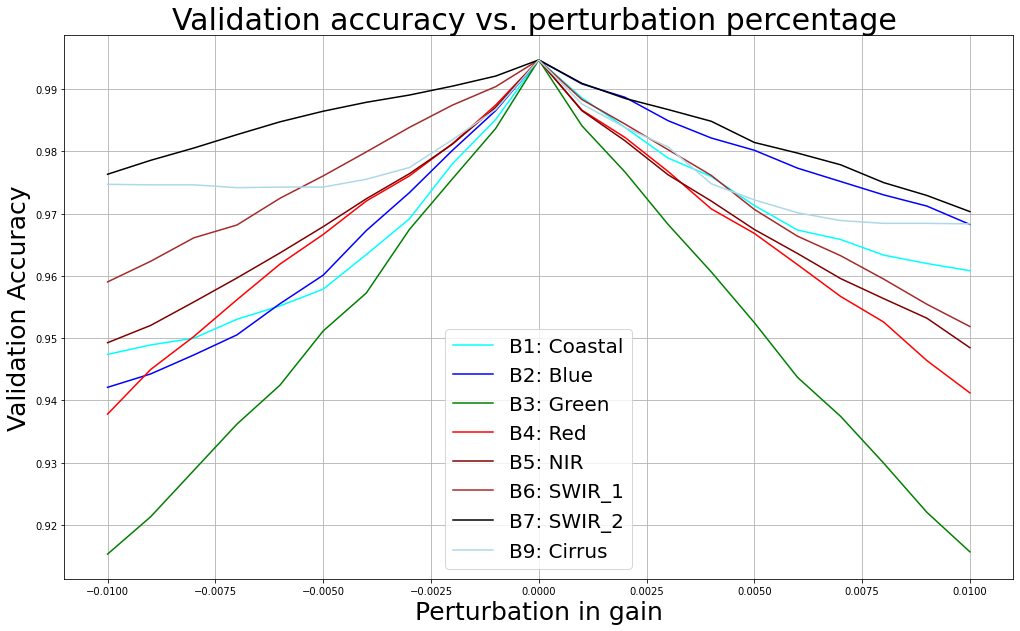

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning:

divide by zero encountered in true_divide



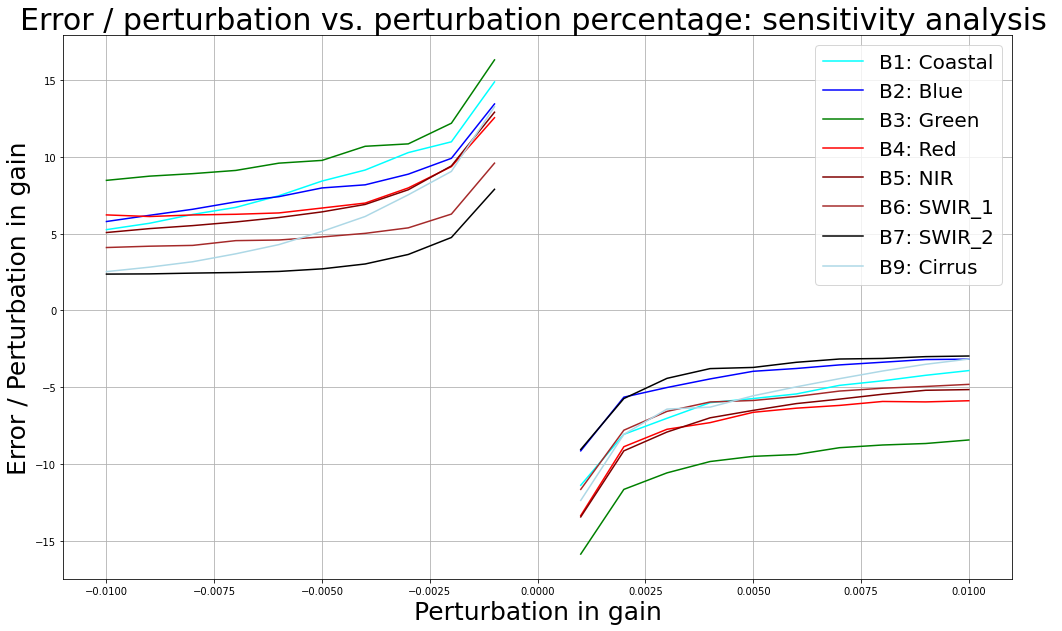

In [ ]:
#Plotting validation accuracies
import numpy as np

import matplotlib.pyplot as plt




plt.figure(figsize=(17,10))

mat_humongous = [[[0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.991, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.992, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.993, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.994, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.001, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.991, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.992, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.993, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.994, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.996, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.997, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.998, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.001, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.991, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.992, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.993, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.994, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.996, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.997, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.998, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.992, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.997, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.998, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999]]]


percentages = np.array(mat_humongous)[0][:, 0]
print("percentages", percentages)
accuracies = np.array([[0.947392005735795, 0.9489155762681484, 0.949991037820398, 0.9530381788851049, 0.9551891019896038, 0.9578777558702276, 0.9634343072235168, 0.9691701021688475, 0.9780426599749059, 0.9851227818605485, 0.9947123140347732, 0.9886180319053594, 0.9838680767162574, 0.9789388779351138, 0.9759813586664277, 0.9713210252733465, 0.9673776662484316, 0.9658540957160782, 0.963344685427496, 0.9620003584871841, 0.9608352751389138], [0.9421043197705682, 0.9442552428750672, 0.9473023839397742, 0.9505287685965227, 0.9555475891736871, 0.9601183007707474, 0.9672880444524108, 0.9733823265818247, 0.980193583079405, 0.9865567305968812, 0.9947123140347732, 0.9908585768058792, 0.9887076537013801, 0.9849435382685069, 0.9821652625918623, 0.980193583079405, 0.9773256856067396, 0.9751747625022406, 0.9730238393977415, 0.9712314034773257, 0.9682738842086396], [0.9153074027603513, 0.9213120630937444, 0.9287506721634702, 0.9361892812331959, 0.9424628069546513, 0.9511561211686682, 0.9572504032980821, 0.9674672880444524, 0.9756228714823445, 0.9836888331242158, 0.9947123140347732, 0.9841369421043198, 0.976698333034594, 0.9682738842086396, 0.9606560315468722, 0.9525004481089802, 0.9437175120989425, 0.937443986377487, 0.9299157555117404, 0.9220290374619108, 0.9156658899444345], [0.9378024735615702, 0.9449722172432335, 0.9502599032084603, 0.9561749417458326, 0.9619107366911633, 0.9666606918802653, 0.9720379996415128, 0.9760709804624484, 0.9812690446316544, 0.9874529485570891, 0.9947123140347732, 0.986646352392902, 0.9822548843878831, 0.9767879548306148, 0.9707832944972217, 0.9668399354723068, 0.9618211148951425, 0.9567126725219574, 0.952590069905001, 0.9464061659795663, 0.9412081018103603], [0.9492740634522315, 0.9520523391288761, 0.9558164545617495, 0.9596701917906435, 0.9637031726115791, 0.9679153970245564, 0.972396486825596, 0.9764294676465316, 0.9811794228356336, 0.9870944613730059, 0.9947123140347732, 0.9865567305968812, 0.9817171536117584, 0.97625022405449, 0.9720379996415128, 0.9674672880444524, 0.9636135508155583, 0.9595805699946227, 0.9563541853378742, 0.9532174224771465, 0.9484674672880444], [0.959042839218498, 0.9623588456712673, 0.9661229611041405, 0.9681842624126188, 0.9724861086216168, 0.9760709804624484, 0.9799247176913425, 0.9838680767162574, 0.9874529485570891, 0.9904104678257752, 0.9947123140347732, 0.988349166517297, 0.9844058074923822, 0.9802832048754258, 0.9761606022584692, 0.9706936727012009, 0.9663918264922029, 0.9632550636314752, 0.9594909481986019, 0.9554579673776662, 0.9518730955368345], [0.9763398458505108, 0.9785803907510306, 0.9805520702634881, 0.982702993367987, 0.9847642946764653, 0.9864671088008604, 0.987901057537193, 0.9890661408854633, 0.990500089621796, 0.9921132819501702, 0.9947123140347732, 0.9909481986019, 0.9885284101093386, 0.9867359741889228, 0.9848539164724861, 0.981448288223696, 0.9797454740993009, 0.9778634163828643, 0.974995518910199, 0.9729342176017207, 0.9703351855171177], [0.9747266535221366, 0.9746370317261158, 0.9746370317261158, 0.9741889227460119, 0.9742785445420327, 0.9742785445420327, 0.9755332496863237, 0.9774153074027604, 0.9818963972038, 0.9867359741889228, 0.9947123140347732, 0.9876321921491307, 0.9838680767162574, 0.9807313138555297, 0.9748162753181574, 0.9722172432335544, 0.9701559419250761, 0.9689012367807851, 0.9684531278006812, 0.9684531278006812, 0.9683635060046604]])
#accuracies = np.array(BAND_ACCURACIES)
#this would be for all the bands combined? 
band1_accuracies = accuracies[0]#coastal-> cyan
band2_accuracies = accuracies[1]#blue
band3_accuracies = accuracies[2]#green
band4_accuracies = accuracies[3]#red
band5_accuracies = accuracies[4]#NIR
band6_accuracies = accuracies[5]#swir_1
band7_accuracies = accuracies[6]#swir_2
band9_accuracies = accuracies[7]#cirrus

label_list = ['B1: Coastal', 'B2: Blue','B3: Green', 'B4: Red', 'B5: NIR', 'B6: SWIR_1', 'B7: SWIR_2', 'B9: Cirrus']
color_list = ['cyan', 'blue', 'green', 'red', 'maroon', 'brown', 'black', '#add8e6']


#DIRECT GRAPHING OF VALIDATION ACCURACY 

title_size = 30
label_size = 25
legend_size = 20

for i, series in enumerate(accuracies):
  plt.plot(percentages - 1, series, color_list[i], label = label_list[i])

plt.title('Validation accuracy vs. perturbation percentage ', fontsize = title_size)
plt.xlabel('Perturbation in gain', fontsize = label_size)
plt.ylabel('Validation Accuracy', fontsize = label_size)
plt.legend(loc='best', fancybox=True, fontsize = legend_size)
plt.grid()
plt.show()


plt.figure(figsize=(17,10))
for i, series in enumerate(accuracies):
  plt.plot(percentages - 1, (series - 1) / (percentages - 1), color_list[i], label = label_list[i])

plt.title('Error / perturbation vs. perturbation percentage: sensitivity analysis ', fontsize = title_size)
plt.xlabel('Perturbation in gain', fontsize = label_size)
plt.ylabel('Error / Perturbation in gain', fontsize = label_size)
plt.legend(loc='best', fancybox=True, fontsize = legend_size)
plt.grid()
plt.show()


#percentages = []

#plt.plot(err)


#for i, theta in enumerate([0., 40., 55.]):

#plt.subplot(3, 1, 1+i)
#plt.title(r'Validation accuracy vs. perturbation percentage '.format(theta))
#plt.plot(d * 1.e3, np.abs(rho_h), color='C0', label='Horizontal Polarization')
#plt.plot(d * 1.e3, np.abs(rho_v), color='C3', label='Vertical Polarization')
#plt.xlabel('Oil thickness (mm)')
#plt.ylabel('Coefficient of Reflection')
#plt.xlim(d.min()*1.e3, d.max()*1.e3)
#plt.legend(loc='best', fancybox=True)
#plt.grid()

#plt.subplots_adjust(top=0.9, hspace=0.5, wspace=0.2)
#plt.show()


##Whole process for one image

In [ ]:
#Plotting validation accuracies

def PlotAccuracies(accuracies):
    import numpy as np

    import matplotlib.pyplot as plt

    plt.figure(figsize=(17,10))

    mat_humongous = [[[0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.991, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.992, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.993, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.994, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.001, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.991, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.992, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.993, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.994, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.996, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.997, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.998, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.001, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.991, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.992, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.993, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.994, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.996, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.997, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.998, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.992, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.997, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.998, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999]]]


    percentages = np.array(mat_humongous)[0][:, 0]
    print("percentages", percentages)

    #this is for one image
    #accuracies = np.array([[0.947392005735795, 0.9489155762681484, 0.949991037820398, 0.9530381788851049, 0.9551891019896038, 0.9578777558702276, 0.9634343072235168, 0.9691701021688475, 0.9780426599749059, 0.9851227818605485, 0.9947123140347732, 0.9886180319053594, 0.9838680767162574, 0.9789388779351138, 0.9759813586664277, 0.9713210252733465, 0.9673776662484316, 0.9658540957160782, 0.963344685427496, 0.9620003584871841, 0.9608352751389138], [0.9421043197705682, 0.9442552428750672, 0.9473023839397742, 0.9505287685965227, 0.9555475891736871, 0.9601183007707474, 0.9672880444524108, 0.9733823265818247, 0.980193583079405, 0.9865567305968812, 0.9947123140347732, 0.9908585768058792, 0.9887076537013801, 0.9849435382685069, 0.9821652625918623, 0.980193583079405, 0.9773256856067396, 0.9751747625022406, 0.9730238393977415, 0.9712314034773257, 0.9682738842086396], [0.9153074027603513, 0.9213120630937444, 0.9287506721634702, 0.9361892812331959, 0.9424628069546513, 0.9511561211686682, 0.9572504032980821, 0.9674672880444524, 0.9756228714823445, 0.9836888331242158, 0.9947123140347732, 0.9841369421043198, 0.976698333034594, 0.9682738842086396, 0.9606560315468722, 0.9525004481089802, 0.9437175120989425, 0.937443986377487, 0.9299157555117404, 0.9220290374619108, 0.9156658899444345], [0.9378024735615702, 0.9449722172432335, 0.9502599032084603, 0.9561749417458326, 0.9619107366911633, 0.9666606918802653, 0.9720379996415128, 0.9760709804624484, 0.9812690446316544, 0.9874529485570891, 0.9947123140347732, 0.986646352392902, 0.9822548843878831, 0.9767879548306148, 0.9707832944972217, 0.9668399354723068, 0.9618211148951425, 0.9567126725219574, 0.952590069905001, 0.9464061659795663, 0.9412081018103603], [0.9492740634522315, 0.9520523391288761, 0.9558164545617495, 0.9596701917906435, 0.9637031726115791, 0.9679153970245564, 0.972396486825596, 0.9764294676465316, 0.9811794228356336, 0.9870944613730059, 0.9947123140347732, 0.9865567305968812, 0.9817171536117584, 0.97625022405449, 0.9720379996415128, 0.9674672880444524, 0.9636135508155583, 0.9595805699946227, 0.9563541853378742, 0.9532174224771465, 0.9484674672880444], [0.959042839218498, 0.9623588456712673, 0.9661229611041405, 0.9681842624126188, 0.9724861086216168, 0.9760709804624484, 0.9799247176913425, 0.9838680767162574, 0.9874529485570891, 0.9904104678257752, 0.9947123140347732, 0.988349166517297, 0.9844058074923822, 0.9802832048754258, 0.9761606022584692, 0.9706936727012009, 0.9663918264922029, 0.9632550636314752, 0.9594909481986019, 0.9554579673776662, 0.9518730955368345], [0.9763398458505108, 0.9785803907510306, 0.9805520702634881, 0.982702993367987, 0.9847642946764653, 0.9864671088008604, 0.987901057537193, 0.9890661408854633, 0.990500089621796, 0.9921132819501702, 0.9947123140347732, 0.9909481986019, 0.9885284101093386, 0.9867359741889228, 0.9848539164724861, 0.981448288223696, 0.9797454740993009, 0.9778634163828643, 0.974995518910199, 0.9729342176017207, 0.9703351855171177], [0.9747266535221366, 0.9746370317261158, 0.9746370317261158, 0.9741889227460119, 0.9742785445420327, 0.9742785445420327, 0.9755332496863237, 0.9774153074027604, 0.9818963972038, 0.9867359741889228, 0.9947123140347732, 0.9876321921491307, 0.9838680767162574, 0.9807313138555297, 0.9748162753181574, 0.9722172432335544, 0.9701559419250761, 0.9689012367807851, 0.9684531278006812, 0.9684531278006812, 0.9683635060046604]])
    #print(accuracies.shape())
    #accuracies = np.array(BAND_ACCURACIES)
    #this would be for all the bands combined? 



    band1_accuracies = accuracies[0]#coastal-> cyan
    band2_accuracies = accuracies[1]#blue
    band3_accuracies = accuracies[2]#green
    band4_accuracies = accuracies[3]#red
    band5_accuracies = accuracies[4]#NIR
    band6_accuracies = accuracies[5]#swir_1
    band7_accuracies = accuracies[6]#swir_2
    band9_accuracies = accuracies[7]#cirrus

    label_list = ['B1: Coastal', 'B2: Blue','B3: Green', 'B4: Red', 'B5: NIR', 'B6: SWIR_1', 'B7: SWIR_2', 'B9: Cirrus']
    color_list = ['cyan', 'blue', 'green', 'red', 'maroon', 'brown', 'black', '#add8e6']


    #DIRECT GRAPHING OF VALIDATION ACCURACY 

    title_size = 30
    label_size = 25
    legend_size = 20

    for i, series in enumerate(accuracies):
      plt.plot(percentages - 1, series, color_list[i], label = label_list[i])

    plt.title('Validation Accuracy vs. perturbation percentage ', fontsize = title_size)
    plt.xlabel('Perturbation in gain', fontsize = label_size)
    plt.ylabel('Validation Accuracy', fontsize = label_size)
    plt.legend(loc='best', fancybox=True, fontsize = legend_size)
    plt.grid()
    plt.show()


    plt.figure(figsize=(17,10))
    for i, series in enumerate(accuracies):
      plt.plot(percentages - 1, (series - 1) / (percentages - 1), color_list[i], label = label_list[i])

    plt.title('Error / perturbation vs. perturbation percentage: sensitivity analysis ', fontsize = title_size)
    plt.xlabel('Perturbation in gain', fontsize = label_size)
    plt.ylabel('Validatoin Error / Perturbation in gain', fontsize = label_size)
    plt.legend(loc='best', fancybox=True, fontsize = legend_size)
    plt.grid()
    plt.show()

accuracies = np.array([[0.947392005735795, 0.9489155762681484, 0.949991037820398, 0.9530381788851049, 0.9551891019896038, 0.9578777558702276, 0.9634343072235168, 0.9691701021688475, 0.9780426599749059, 0.9851227818605485, 0.9947123140347732, 0.9886180319053594, 0.9838680767162574, 0.9789388779351138, 0.9759813586664277, 0.9713210252733465, 0.9673776662484316, 0.9658540957160782, 0.963344685427496, 0.9620003584871841, 0.9608352751389138], [0.9421043197705682, 0.9442552428750672, 0.9473023839397742, 0.9505287685965227, 0.9555475891736871, 0.9601183007707474, 0.9672880444524108, 0.9733823265818247, 0.980193583079405, 0.9865567305968812, 0.9947123140347732, 0.9908585768058792, 0.9887076537013801, 0.9849435382685069, 0.9821652625918623, 0.980193583079405, 0.9773256856067396, 0.9751747625022406, 0.9730238393977415, 0.9712314034773257, 0.9682738842086396], [0.9153074027603513, 0.9213120630937444, 0.9287506721634702, 0.9361892812331959, 0.9424628069546513, 0.9511561211686682, 0.9572504032980821, 0.9674672880444524, 0.9756228714823445, 0.9836888331242158, 0.9947123140347732, 0.9841369421043198, 0.976698333034594, 0.9682738842086396, 0.9606560315468722, 0.9525004481089802, 0.9437175120989425, 0.937443986377487, 0.9299157555117404, 0.9220290374619108, 0.9156658899444345], [0.9378024735615702, 0.9449722172432335, 0.9502599032084603, 0.9561749417458326, 0.9619107366911633, 0.9666606918802653, 0.9720379996415128, 0.9760709804624484, 0.9812690446316544, 0.9874529485570891, 0.9947123140347732, 0.986646352392902, 0.9822548843878831, 0.9767879548306148, 0.9707832944972217, 0.9668399354723068, 0.9618211148951425, 0.9567126725219574, 0.952590069905001, 0.9464061659795663, 0.9412081018103603], [0.9492740634522315, 0.9520523391288761, 0.9558164545617495, 0.9596701917906435, 0.9637031726115791, 0.9679153970245564, 0.972396486825596, 0.9764294676465316, 0.9811794228356336, 0.9870944613730059, 0.9947123140347732, 0.9865567305968812, 0.9817171536117584, 0.97625022405449, 0.9720379996415128, 0.9674672880444524, 0.9636135508155583, 0.9595805699946227, 0.9563541853378742, 0.9532174224771465, 0.9484674672880444], [0.959042839218498, 0.9623588456712673, 0.9661229611041405, 0.9681842624126188, 0.9724861086216168, 0.9760709804624484, 0.9799247176913425, 0.9838680767162574, 0.9874529485570891, 0.9904104678257752, 0.9947123140347732, 0.988349166517297, 0.9844058074923822, 0.9802832048754258, 0.9761606022584692, 0.9706936727012009, 0.9663918264922029, 0.9632550636314752, 0.9594909481986019, 0.9554579673776662, 0.9518730955368345], [0.9763398458505108, 0.9785803907510306, 0.9805520702634881, 0.982702993367987, 0.9847642946764653, 0.9864671088008604, 0.987901057537193, 0.9890661408854633, 0.990500089621796, 0.9921132819501702, 0.9947123140347732, 0.9909481986019, 0.9885284101093386, 0.9867359741889228, 0.9848539164724861, 0.981448288223696, 0.9797454740993009, 0.9778634163828643, 0.974995518910199, 0.9729342176017207, 0.9703351855171177], [0.9747266535221366, 0.9746370317261158, 0.9746370317261158, 0.9741889227460119, 0.9742785445420327, 0.9742785445420327, 0.9755332496863237, 0.9774153074027604, 0.9818963972038, 0.9867359741889228, 0.9947123140347732, 0.9876321921491307, 0.9838680767162574, 0.9807313138555297, 0.9748162753181574, 0.9722172432335544, 0.9701559419250761, 0.9689012367807851, 0.9684531278006812, 0.9684531278006812, 0.9683635060046604]])
#percentages = []


{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32615', 'crs_transform': [30, 0, 612885, 0, -30, 4583415]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32615', 'crs_transform': [30, 0, 612885, 0, -30, 4583415]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32615', 'crs_transform': [30, 0, 612885, 0, -30, 4583415]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32615', 'crs_transform': [30, 0, 612885, 0, -30, 4583415]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7601, 7731], 'crs': 'EPSG:32615', 'crs_transform': [30, 0, 612885, 0, -30, 4583415]}, {'

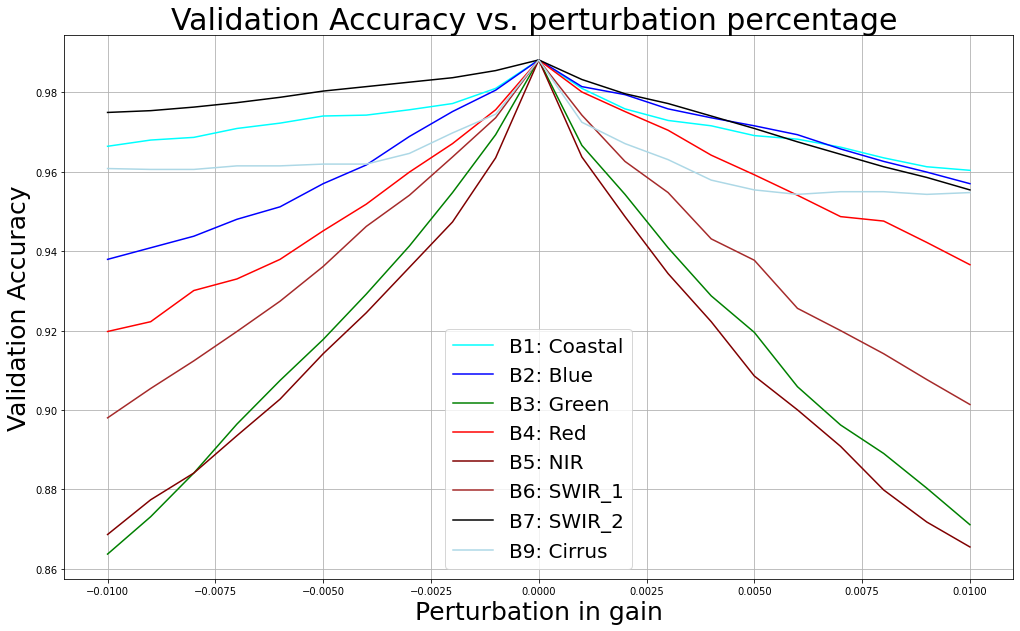

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



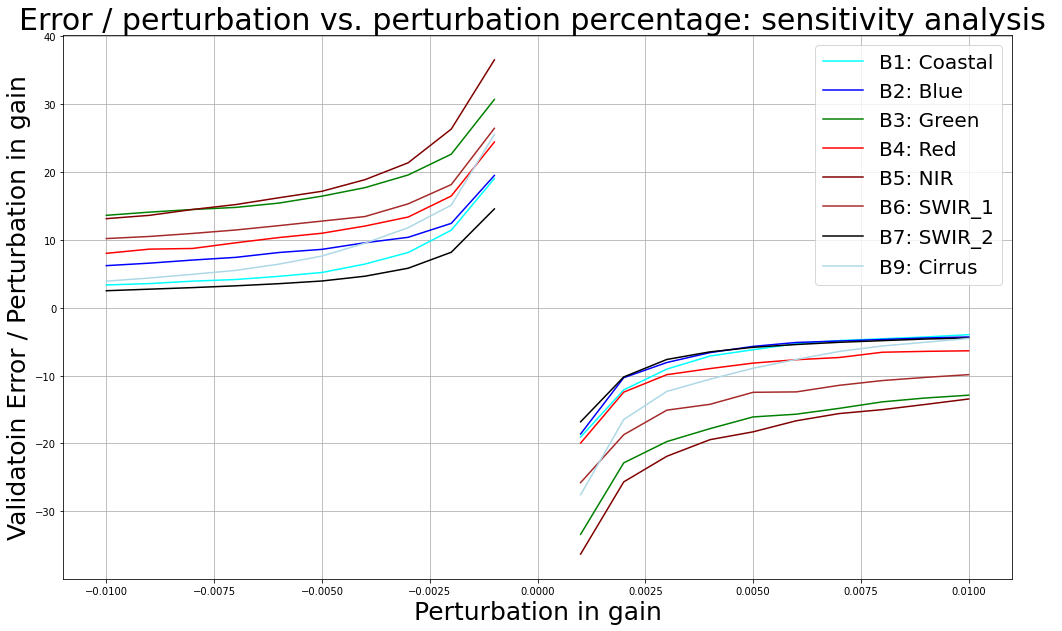

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


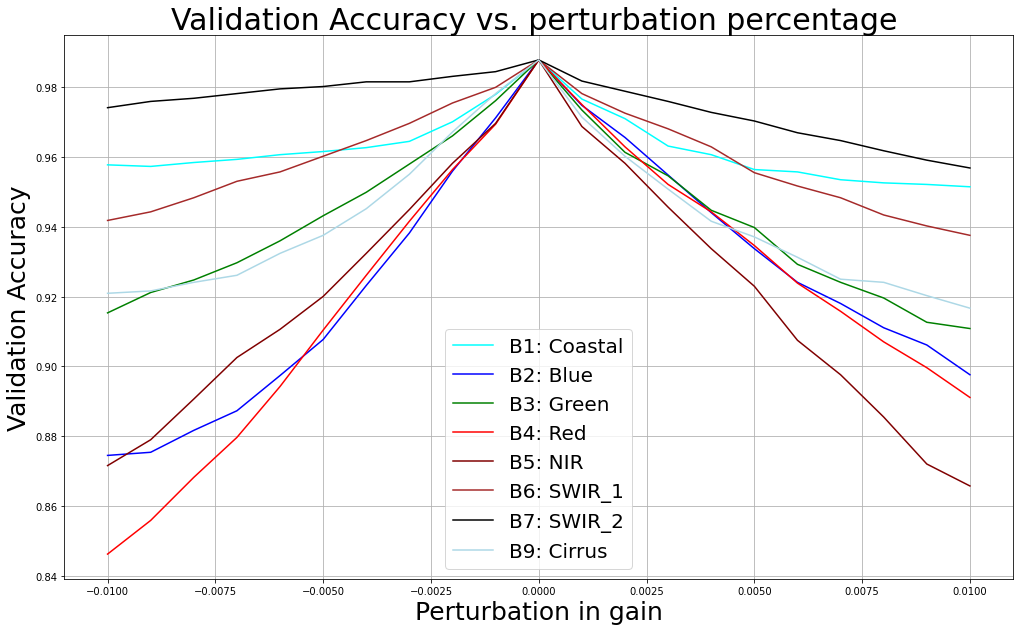

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



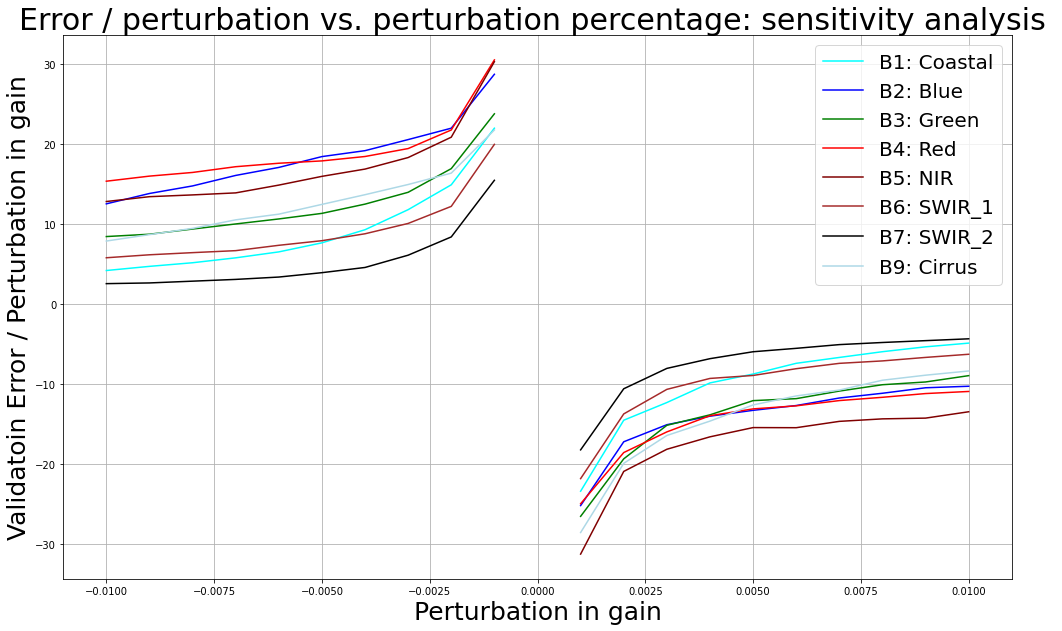

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


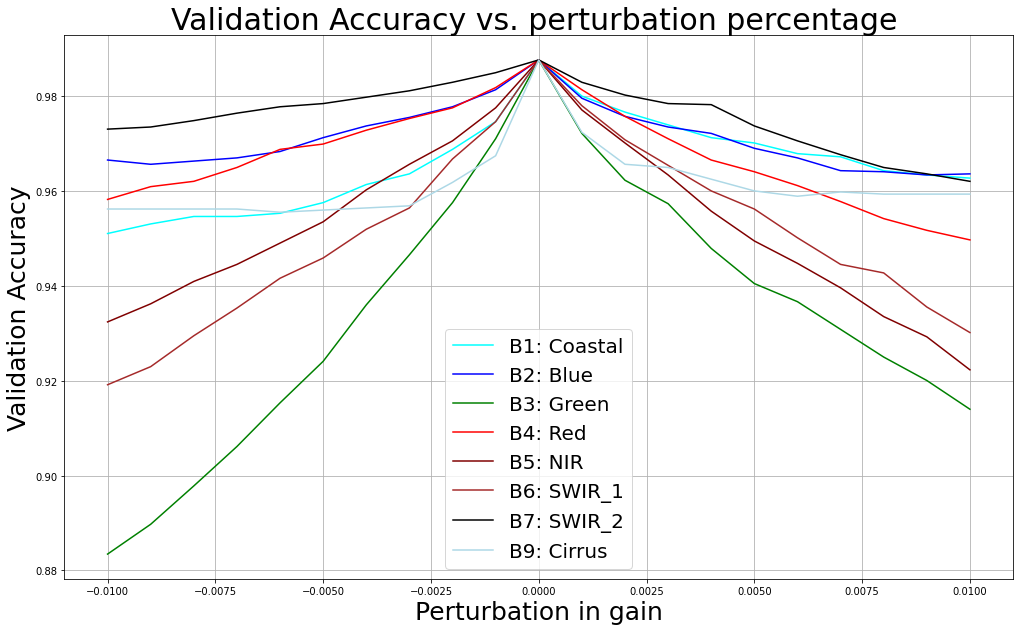

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



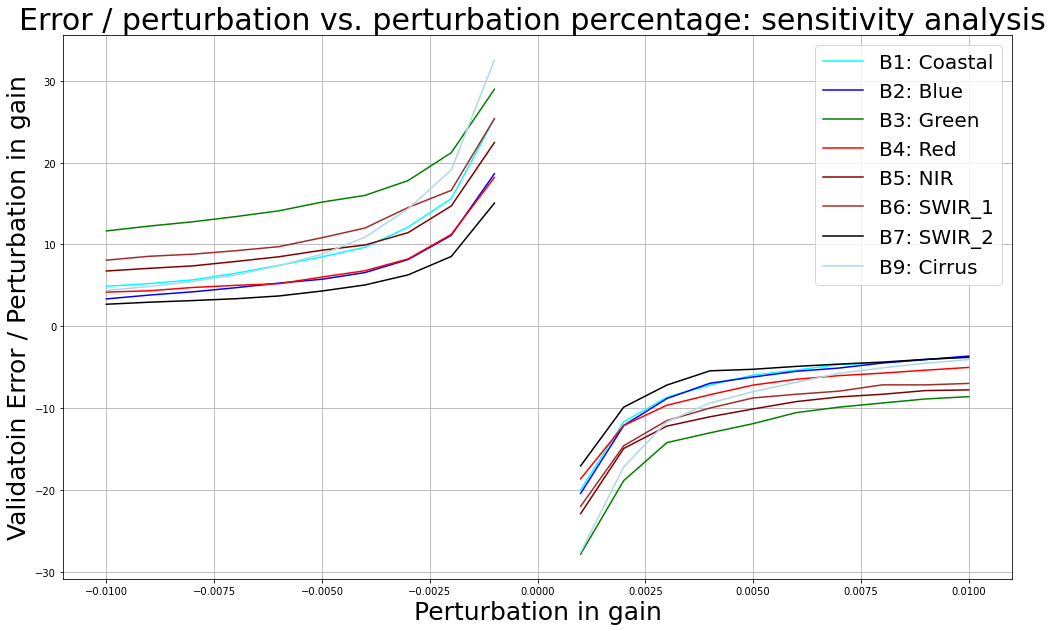

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


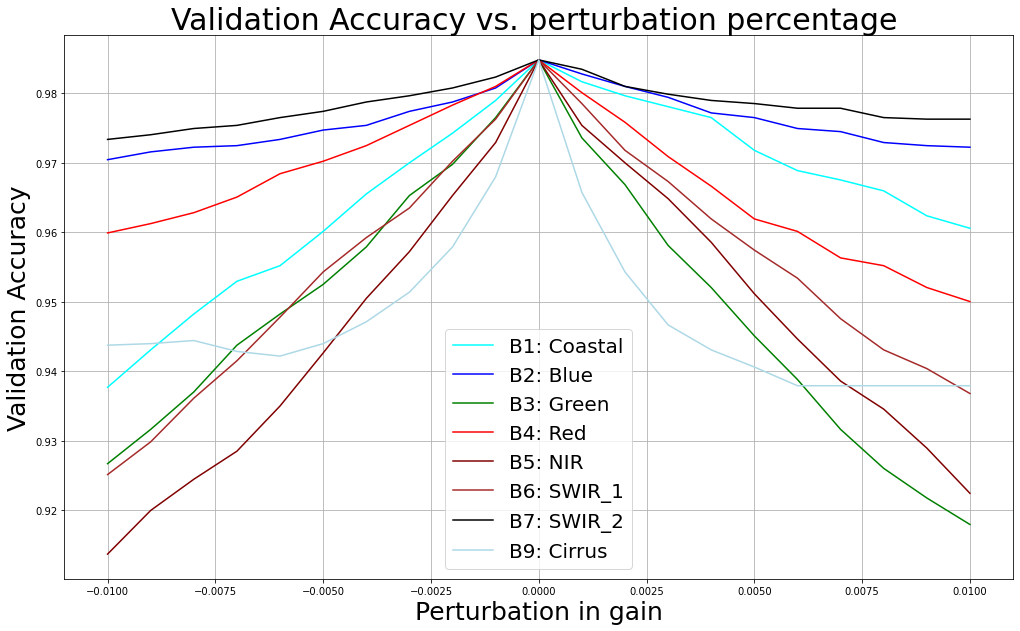

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



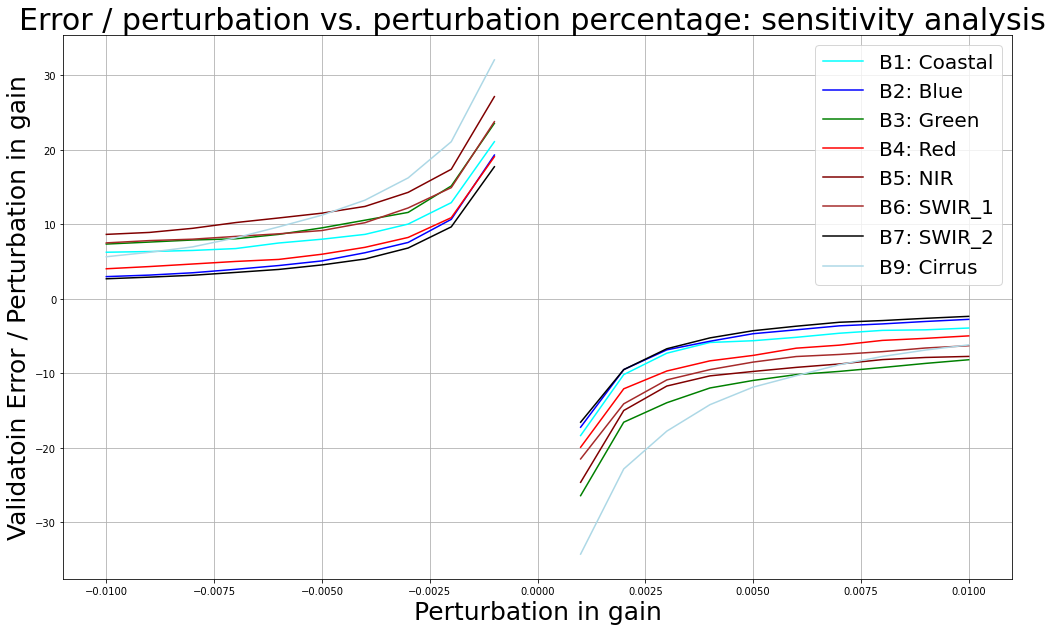

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


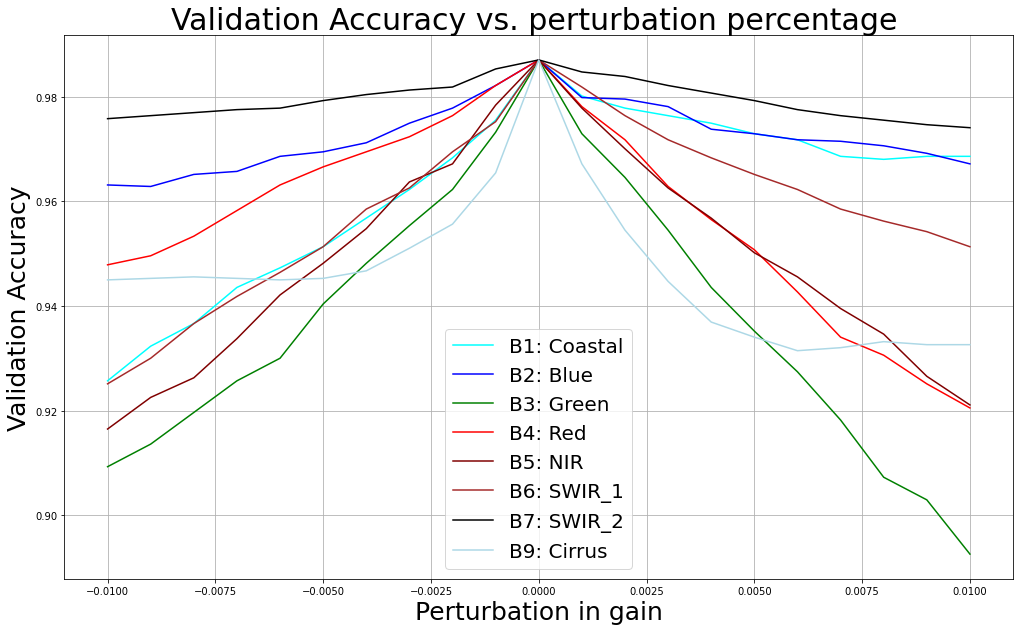

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



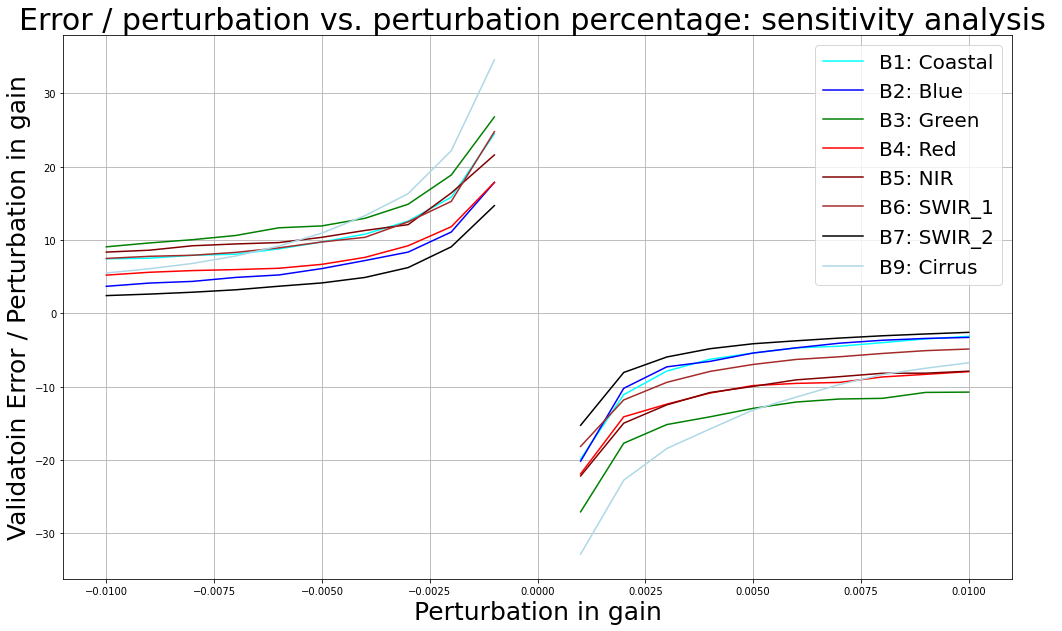

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


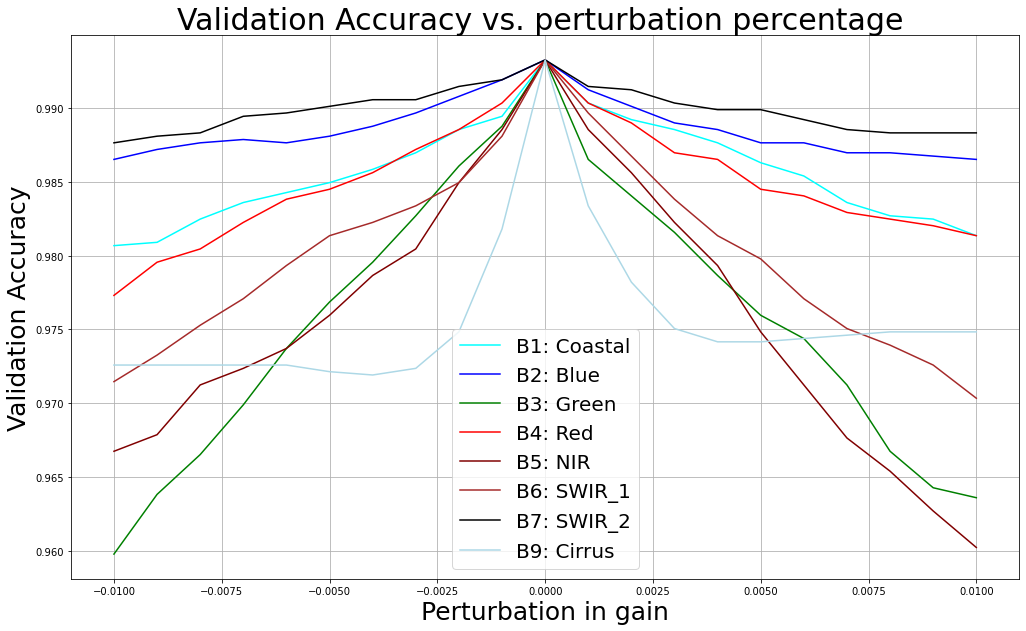

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



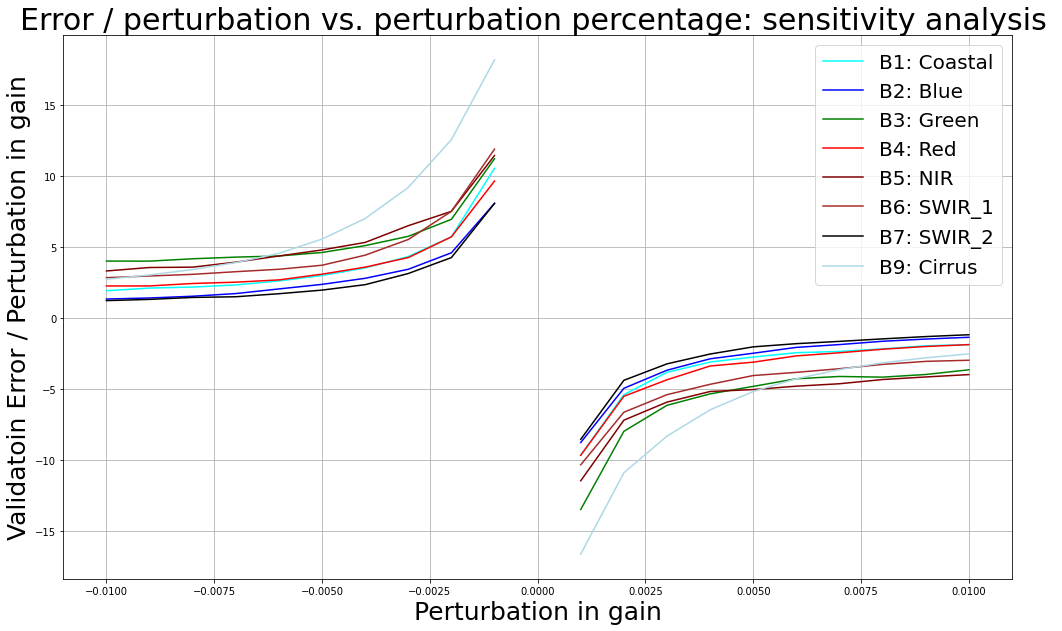

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


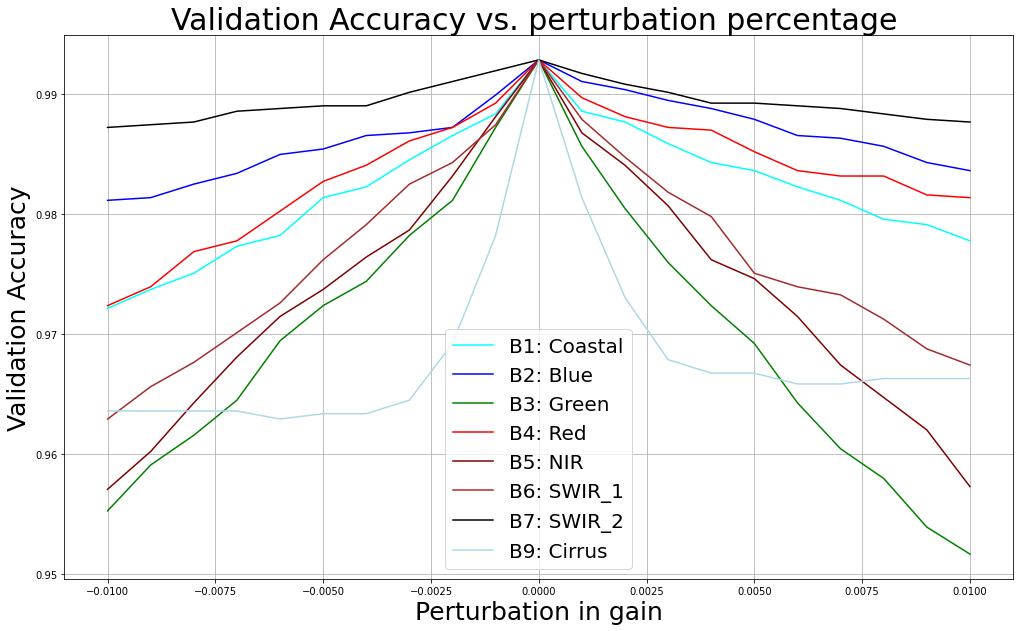

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



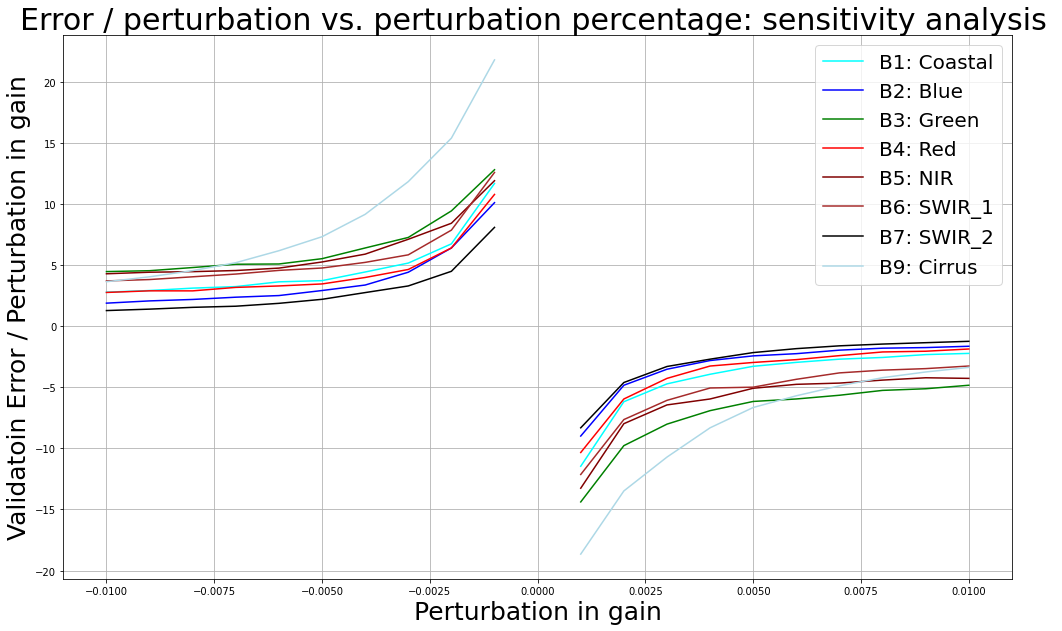

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


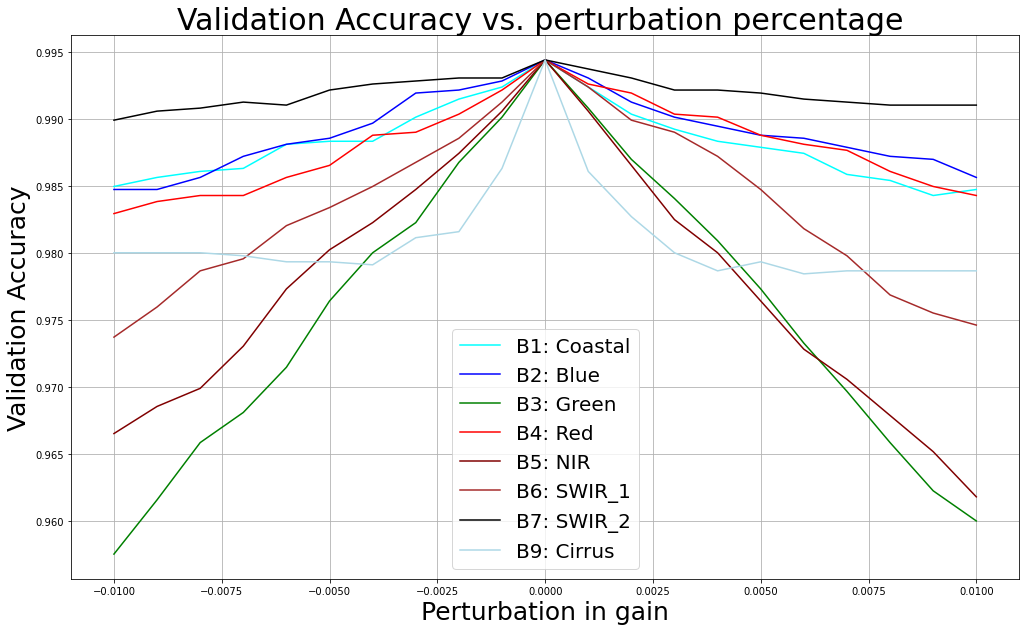

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



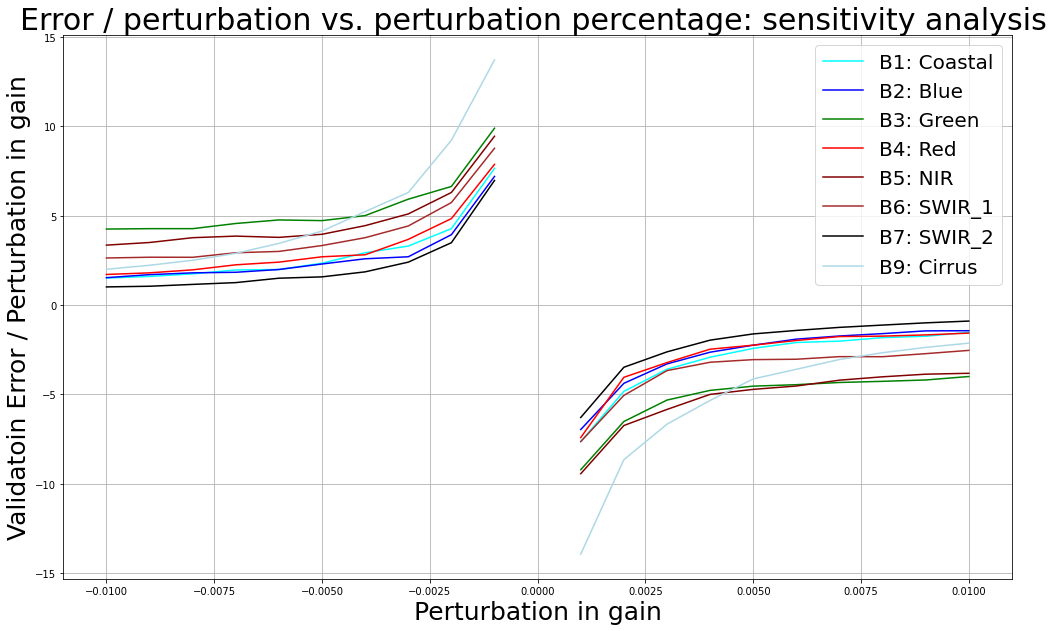

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


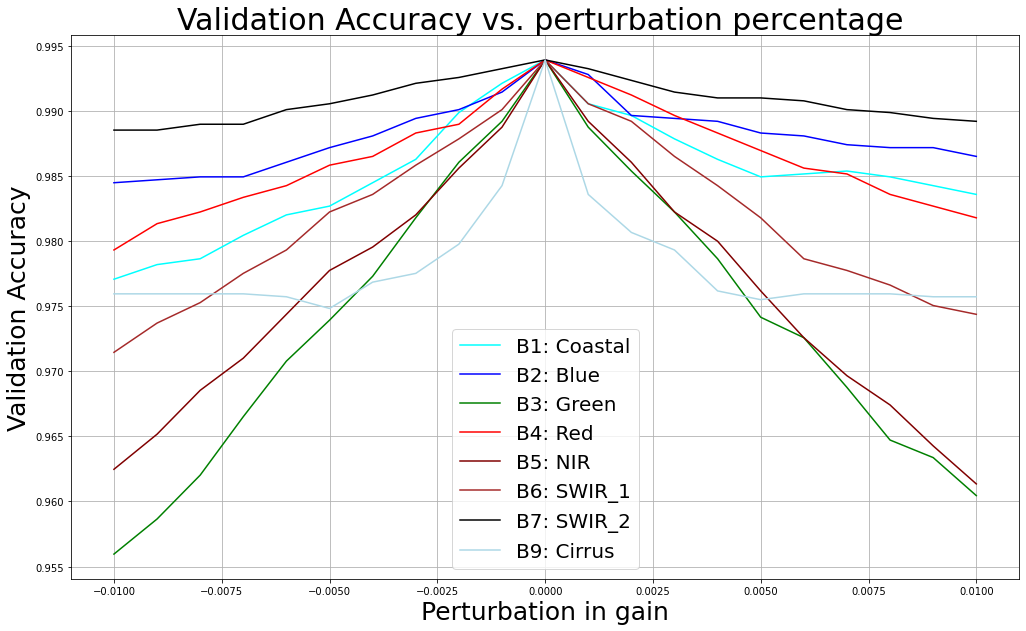

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



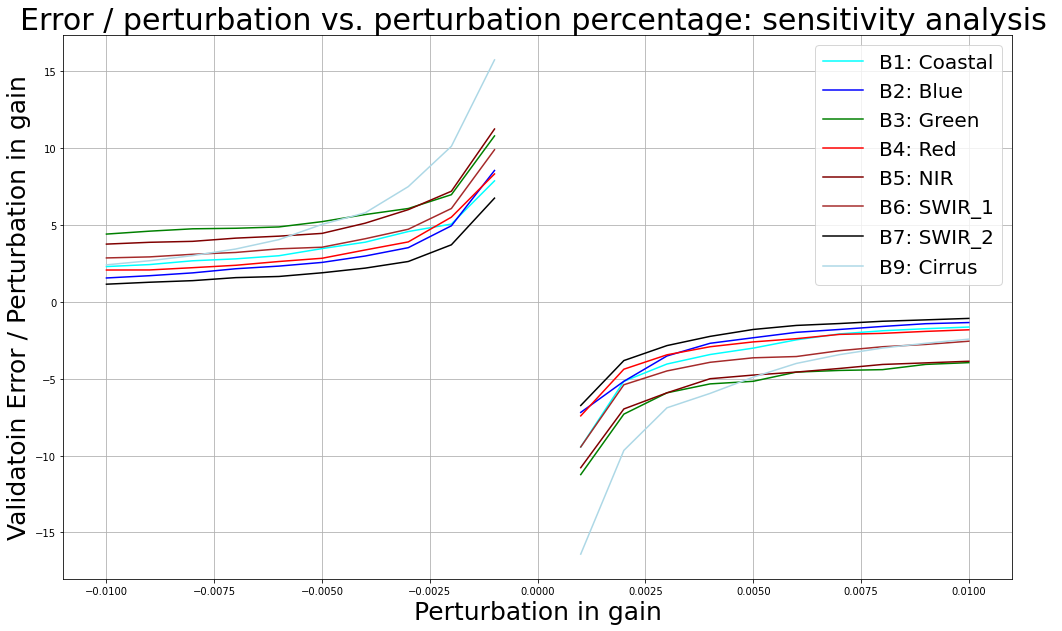

percentages [0.99  0.991 0.992 0.993 0.994 0.995 0.996 0.997 0.998 0.999 1.    1.001
 1.002 1.003 1.004 1.005 1.006 1.007 1.008 1.009 1.01 ]


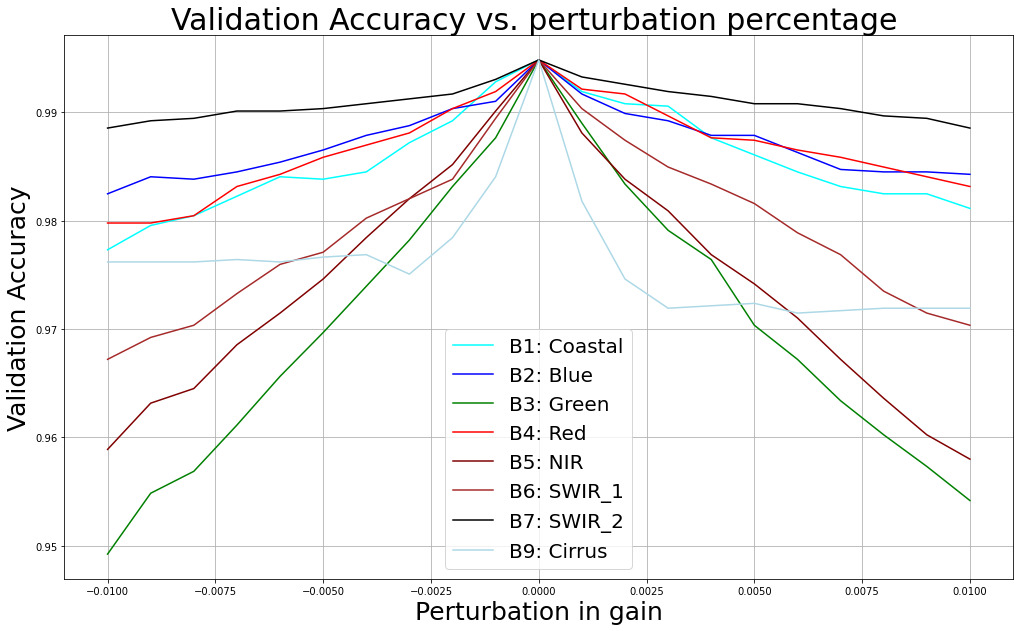

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

divide by zero encountered in true_divide



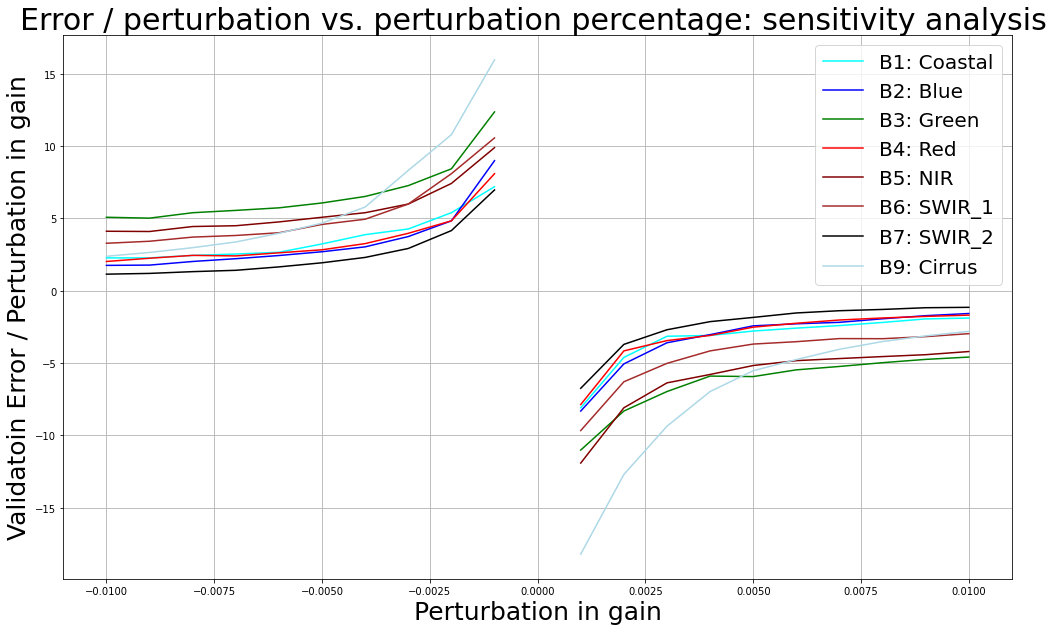

In [ ]:
###Outline for a single image


def Classify_thing(raw_img, classes):
    '''
    :raw_img = raw image, DN, nothing done to it
    :classes = feature collection with ground truth


    outline:
      -- establish classification function

      -- perform cloud masking on raw_img
      -- add gain/bias coefficients to raw_img
      -- generate perturbation factors from mat_humongous


      -- unperturbed_toa_reflectance --> perform toa_reflectance(img)
      -- perturbed_toa_reflectance --> perform perturb_img(img)
      -- add indices to both unperturbed_toa and perturbed_toa

      -- build up band accuracies by performing classify_rf on both images

    '''
    
    #big big function

    print(raw_img.getInfo())
    def classify_rf(image1, image2, classes):
      
      #//trains on image1, tests on image2
      bands = ['B1', 'B2','B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'NDVI', 'NDBI', 'MNDWI', 'GCVI']
      label = 'label'
      #this has to be a Feature Class, can't be a raster/image
      training = image1.select(bands).sampleRegions(
                                                    collection = classes,
                                                    properties = [label],
                                                    geometries = True,
                                                    scale = 30
                                                    )      
      #//this has to be a Feature Class, can't be a raster/image
      validation = image2.select(bands).sampleRegions(
                                                      collection = classes,
                                                      properties = [label],
                                                      geometries = True,
                                                      scale = 30)#same points we would want to test
        # Trained with 70% of our data.
      classifier = ee.Classifier.smileRandomForest(50, 8)\
                                  .train(
                                      features = training,
                                      classProperty = 'label',
                                      inputProperties= bands
                                      );
      classified = image1.classify(classifier)

      trainAccuracy = classifier.confusionMatrix()
      #print('Resubstitution error matrix: ', trainAccuracy.getInfo())
      #print('Training overall accuracy: ', trainAccuracy.accuracy().getInfo())



      #//we then classify the second image
      
      validated = validation.classify(classifier);



      #print(validated.getInfo(), "validated info");
      testAccuracy = validated.errorMatrix('label', 'classification');
      print('Validation overall accuracy: ', testAccuracy.accuracy().getInfo())

      #print('Validation error matrix: ', testAccuracy.getInfo());
      #print('Validation overall accuracy: ', testAccuracy.accuracy());

      confMatrix = classifier.confusionMatrix();
      #OA = confMatrix.accuracy();
      #CA = confMatrix.consumersAccuracy();
      #Kappa = confMatrix.kappa();
      #print("kappa", Kappa)
      #Order = confMatrix.order();
      #PA = confMatrix.producersAccuracy();
      #print("PA", PA.getInfo())
      
      #print('Confusion Matrix', confMatrix.getInfo());
      #print('Overall Accuracy', OA);
      #print('Consumers Accuracy', CA);
      #print('Kappa', Kappa);
      #print('Order', Order);
      #print('Producers Accuracy', PA);
      return validated, testAccuracy.accuracy()#testAccuracy#;//TYPE: Image 

    toa_img = ref_add(ref_mult(raw_img))
    toa_unperturbed = addIndicesL8(toa_reflectance(toa_img))


    BAND_ACCURACIES = []    
    for band in mat_humongous:
      band_accuracy = []
      for row in band:
        toa_perturbed = addIndicesL8(perturb_image(ee.List(row))(toa_img))
        #print("toa pert", toa_perturbed.getInfo())
        test_thing = classify_rf(toa_unperturbed, toa_perturbed, classes)
        band_accuracy.append(test_thing[1].getInfo())
      BAND_ACCURACIES.append(band_accuracy)

    return np.array(BAND_ACCURACIES)



# def ClassifyPerturb(image, classe):
#     '''
#     image: raw image straight from GEE, nothing has been done
#     classes --> input this!!!
#     '''
#     mat_humongous = [[[0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.991, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.992, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.993, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.994, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.998, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.001, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.991, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.992, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.993, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.994, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.996, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.997, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.998, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.001, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.991, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.992, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.993, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.994, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.996, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.997, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.998, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.992, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.997, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.998, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999, 1.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.992], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.993], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.994], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.997], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.001], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0019999999999998], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0029999999999997], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0039999999999996], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0049999999999994], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0059999999999993], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0069999999999992], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0079999999999991], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.008999999999999], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.009999999999999]]]
#     masked_img = maskL8((ref_add(ref_mult(image))))
#     toa_img = toa_reflectance(masked_img)
#     indicised_img = addIndicesL8(toa_img)

#     BAND_ACCURACIES = []

#     for band in mat_humongous:
#       band_accuracy = []
#       for row in band:
#           img_perturbed = addIndicesL8(perturb_image(ee.List(row))(masked_img))
#           print(img_perturbed.getInfo())
#           test_thing = classify_rf(indicised_img, img_perturbed, classe)
#           band_accuracy.append(test_thing[1].getInfo())
#       BAND_ACCURACIES.append(band_accuracy)
#       return np.array(BAND_ACCURACIES)

#print(classes_illi.getInfo())


accuracies_illi_1 = Classify_thing(raw_illi_1, classes_illi)
accuracies_illi_2 = Classify_thing(raw_illi_2, classes_illi)
accuracies_illi_4 = Classify_thing(raw_illi_4, classes_illi)
accuracies_illi_5 = Classify_thing(raw_illi_5, classes_illi)
accuracies_illi_7 = Classify_thing(raw_illi_7, classes_illi)

accuracies_cali_1 = Classify_thing(raw_cali_1, classes_cali)
accuracies_cali_2 = Classify_thing(raw_cali_2, classes_cali)
accuracies_cali_4 = Classify_thing(raw_cali_4, classes_cali)
accuracies_cali_5 = Classify_thing(raw_cali_5, classes_cali)
accuracies_cali_6 = Classify_thing(raw_cali_6, classes_cali)



#plot them 
PlotAccuracies(accuracies_illi_1)
PlotAccuracies(accuracies_illi_2)
PlotAccuracies(accuracies_illi_4)
PlotAccuracies(accuracies_illi_5)
PlotAccuracies(accuracies_illi_7)

PlotAccuracies(accuracies_cali_1)
PlotAccuracies(accuracies_cali_2)
PlotAccuracies(accuracies_cali_4)
PlotAccuracies(accuracies_cali_5)
PlotAccuracies(accuracies_cali_6)


In [ ]:
##########################################################################################
# This is the method for painting an empty image with the feature collection
##########################################################################################
#// Paint the interior of the polygons with different colors.
#var fills = empty.paint({
#  featureCollection: ecoregions,
#  color: 'BIOME_NUM',
#});
#var palette = ['FF0000', '00FF00', '0000FF'];
#Map.addLayer(fills, {palette: palette, max: 14}, 'colored fills');

##########################################################################################
test_thing = classify_rf(illi_2_toa_unperturbed, illi_2_toa_perturbed, classes_illi)[0]


print("classes illi", classes_illi.getInfo())
def pixelize(feature):
  target_proj = ee.Image(raw_illi_1).select('B1').projection()
  areaM2 = 30**2
  return feature.buffer(ee.Number(areaM2).sqrt().divide(2), 1).bounds().transform(target_proj, 0.001)

test_thing = test_thing.map(pixelize)
#print("classes illi", classes_illi.getInfo())
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

cropland_palette = croplandcover.get('cropland_class_palette').getInfo()


# Create empty image

empty = ee.Image().byte();


# Create a folium map object.

my_map = folium.Map(location= centroid_illi, zoom_start=15, height=500)


vis_params = {'bands':['B4','B3','B1'], 'min': 0, 'max': 1, 'gamma': 1.4}


print("classes illi", classes_illi.getInfo())
cropland_img = empty.paint(**{'featureCollection': classes_illi,
                            'color': 'label'})

classified_img = empty.paint(**{'featureCollection': test_thing,
                            'color': 'label'})


print("cropland img", cropland_img.getInfo())
print("classified img", classified_img.getInfo())
cropland_palette = croplandcover.get('cropland_class_palette').getInfo()
#print(cropland_palette)

#cropland_palette = cropland_class_palette

my_map.add_ee_layer(cropland_img, {'palette': cropland_palette, max: 250}, 'crop cover')

my_map.add_ee_layer(classified_img, {'palette': cropland_palette, max: 250}, 'classified')

my_map.add_ee_layer(croplandcover, {}, 'cropland cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)



#now to get the thumbnails



NameError: ignored

In [ ]:
##########################################################################################
# This is the method for painting an empty image with the feature collection
##########################################################################################
#// Paint the interior of the polygons with different colors.
#var fills = empty.paint({
#  featureCollection: ecoregions,
#  color: 'BIOME_NUM',
#});
#var palette = ['FF0000', '00FF00', '0000FF'];
#Map.addLayer(fills, {palette: palette, max: 14}, 'colored fills');

##########################################################################################

toa_cali_2 = addIndicesL8(ref_add(ref_mult(raw_cali_2)))

cali_2_toa_perturbed = addIndicesL8(perturb_image(ee.List(row))(toa_cali_2))


test_thing = classify_rf(toa_cali_2, cali_2_toa_perturbed, classes_cali)[0]


print("classes illi", classes_cali.getInfo())
def pixelize(feature):
  target_proj = ee.Image(raw_cali_1).select('B1').projection()
  areaM2 = 30**2
  return feature.buffer(ee.Number(areaM2).sqrt().divide(2), 1).bounds().transform(target_proj, 0.001)

test_thing = test_thing.map(pixelize)
#print("classes illi", classes_illi.getInfo())
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

cropland_palette = croplandcover.get('cropland_class_palette').getInfo()


# Create empty image

empty = ee.Image().byte();


# Create a folium map object.

my_map = folium.Map(location= centroid_cali, zoom_start=15, height=500)


vis_params = {'bands':['B4','B3','B1'], 'min': 0, 'max': 1, 'gamma': 1.4}


print("classes cali", classes_cali.getInfo())
cropland_img = empty.paint(**{'featureCollection': classes_cali,
                            'color': 'label'})

classified_img = empty.paint(**{'featureCollection': test_thing,
                            'color': 'label'})


print("cropland img", cropland_img.getInfo())
print("classified img", classified_img.getInfo())
cropland_palette = croplandcover.get('cropland_class_palette').getInfo()
#print(cropland_palette)

#cropland_palette = cropland_class_palette

my_map.add_ee_layer(cropland_img, {'palette': cropland_palette, max: 250}, 'crop cover')

my_map.add_ee_layer(classified_img, {'palette': cropland_palette, max: 250}, 'classified')

my_map.add_ee_layer(croplandcover, {}, 'cropland cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)



#now to get the thumbnails

